In [4]:
%matplotlib inline
import numpy as np
import json
import seaborn as sns
import pandas as pd
import os
import glob
import SimpleITK as itk
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
sns.set_style("whitegrid")
import sys
sys.path.append('../src/')
from utils import save_json, subfiles, join, maybe_mkdir_p, reconstruct_seg_df_from_json, reconstruct_calib_df_from_json, reconstruct_UED_df_from_json



# compare between different group using UED, FND, FPD

In [5]:
## directorys for main internal probability maps 

NNUNET_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
DROP1_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout1__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
DROP2_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
DROP3_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout3__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
DROP5_UREGIONS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout5__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"

PHISEG_UREGIONS = "/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"
PHISEG_GAMMA_UREGIONS= "/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/u_regions/Task901_AUH/imagesTs"

studies = [
join(NNUNET_UREGIONS,'f0'),
join(NNUNET_UREGIONS,'f0_tta'),
join(DROP2_UREGIONS,'f0_mc10_tta')
,join(NNUNET_UREGIONS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_UREGIONS,'f0_tta_snap')
,join(DROP2_UREGIONS,'f01234_mc10_tta_snap')
,join(PHISEG_UREGIONS,'f01234_tta')

]
#,join(PH_GAMM_PMAP,'f0_tta')]

def compute_best_ued(studies):
    groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots',"Complex", 'PhiSeg' ]

    # Define the base directory

    for index, group in enumerate(groups):

        base_dir = studies[index]

        # Define the subdirectories to iterate through
        #subdirs = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] #best th leads to results without 
        subdirs = ["7"]
        # Initialize a dictionary to store the results for each patient

        results = [] 
        # Iterate through the subdirectories
        for gtv in ['GTV-T', 'GTV-N']:
            patient_results = {}
            for subdir in subdirs:
                # Obtain the UED summary.json file path
                ued_path = os.path.join(base_dir, subdir, gtv+"_union", "summary.json")
                # Obtain the FND and FPD summary.json file path
                
                fpnd_path = os.path.join(base_dir, subdir, gtv, "summary.json")
                # Check if the summary.json files exist
                if os.path.exists(ued_path) and os.path.exists(fpnd_path):
                    # Read the UED summary.json file
                    with open(ued_path) as f:
                        ued_data = json.load(f)
                    # Read the FND and FPD summary.json file
                    with open(fpnd_path) as f:
                        fpnd_data = json.load(f)

                    # Iterate through the patients in the UED summary.json file
                    for patient_data in ued_data["results"]["all"]:
                        # Obtain the unique patient ID
                        patient_id = os.path.basename(patient_data["reference"]).split(".nii.gz")[0]
                        # Check if the patient ID already exists in the patient_results dictionary
                        if patient_id not in patient_results:
                            # Create a new dictionary for the patient ID
                            patient_results[patient_id] = {}
                        # Obtain the UED value for the patient
                        ued_value = patient_data["1"]["Dice"]
                        ued_volume = patient_data["1"]["Total Positives Test"]

                        # Check if the UED value is higher than the current value for the patient
                        if "UED" not in patient_results[patient_id]:
                            # Add the UED value to the patient's dictionary
                            patient_results[patient_id]["UED"]= ued_value
                            patient_results[patient_id]["UED_volume"]= ued_volume

                            patient_results[patient_id]["UED_th"]= subdir
                        if ued_value > patient_results[patient_id]["UED"]:
                            # Add the UED value to the patient's dictionary
                            patient_results[patient_id]["UED"] = ued_value
                            patient_results[patient_id]["UED_volume"]= ued_volume
                            patient_results[patient_id]["UED_th"] = subdir
                        if ued_volume == 0:
                            patient_results[patient_id]["UED"]= np.nan
                            patient_results[patient_id]["UED_volume"]= ued_volume
                            patient_results[patient_id]["UED_th"]= 0

                    for patient_data in fpnd_data["results"]["all"]:
                        # Obtain the unique patient ID
                        patient_id = os.path.basename(patient_data["reference"]).split(".nii.gz")[0]
                        if patient_id not in patient_results:
                            print("fError, some thing went wrong {patient_id}")
                            # Create a new dictionary for the patient ID
                            break
                        # Obtain the FND value for the patient
                        fnd_value = patient_data["1"]["Dice"]
                        fnd_volume = patient_data["1"]["Total Positives Test"]
                        # Obtain the FPD value for the patient
                        fpd_value = patient_data["2"]["Dice"]
                        fpd_volume = patient_data["2"]["Total Positives Test"]

                        # Check if the FND value is higher than the current value for the patient
                        if "FND" not in patient_results[patient_id]:
                            # Add the FND value to the patient's dictionary
                            patient_results[patient_id]["FND"] = fnd_value
                            patient_results[patient_id]["FND_volume"]= fnd_volume
                            patient_results[patient_id]["FND_th"] = subdir
                        if fnd_value > patient_results[patient_id]["FND"]:
                            # Add the FND value to the patient's dictionary
                            patient_results[patient_id]["FND"]= fnd_value
                            patient_results[patient_id]["FND_volume"]= fnd_volume
                            patient_results[patient_id]["FND_th"] = subdir
                        if fnd_volume == 0:
                            patient_results[patient_id]["FND"]= np.nan
                            patient_results[patient_id]["FND_volume"]= fnd_volume
                            patient_results[patient_id]["FND_th"]= 0

                        # Check if the FPD value is higher than the current value for the patient
                        if "FPD" not in patient_results[patient_id]:
                            # Add the FPD value to the patient's dictionary
                            patient_results[patient_id]["FPD"] = fpd_value
                            patient_results[patient_id]["FPD_volume"]= fpd_volume
                            patient_results[patient_id]["FPD_th"]= subdir
                        if fpd_value > patient_results[patient_id]["FPD"]:
                            # Add the FPD value to the patient's dictionary
                            patient_results[patient_id]["FPD"] = fpd_value
                            patient_results[patient_id]["FPD_volume"]= fpd_volume
                            patient_results[patient_id]["FPD_th"]= subdir
                        if fpd_volume == 0:
                            patient_results[patient_id]["FPD"]= np.nan
                            patient_results[patient_id]["FPD_volume"]= fpd_volume
                            patient_results[patient_id]["FPD_th"]= 0

                        patient_results[patient_id]["GTV"] = gtv
                        patient_results[patient_id]["Uncertainty estimation methods"] = group
            results.append(patient_results)

        dft = pd.DataFrame(results[0]).T
        dfn = pd.DataFrame(results[1]).T

        dft.index.names = ['PatientID']
        dfn.index.names = ['PatientID']
        dft= dft.reset_index(drop=False)
        dfn= dfn.reset_index(drop=False)

        df_ued = pd.concat([dft, dfn])
        df_ued= df_ued.reset_index(drop=True)

        if index == 0:
            df_ued_all = df_ued
        else:
            df_ued_all = pd.concat([df_ued_all, df_ued], axis=0)
            df_ued_all= df_ued_all.reset_index(drop=True)

    return df_ued_all
    
df_ued_all_internal = compute_best_ued(studies)

DROP2_UREGIONS_EXT="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/u_regions/Task711_NKI_origin/imagesAll_ct_correct"
NNUNET_UREGIONS_EXT="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/u_regions/Task711_NKI_origin/imagesAll_ct_correct"
PHISEG_UREGIONS_EXT="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/u_regions/Task711_NKI_origin/imagesAll_ct_correct"

studies_ext = [
join(NNUNET_UREGIONS_EXT,'f0'),
join(NNUNET_UREGIONS_EXT,'f0_tta'),
join(DROP2_UREGIONS_EXT,'f0_mc10_tta')
,join(NNUNET_UREGIONS_EXT,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_UREGIONS_EXT,'f0_tta_snap')
,join(DROP2_UREGIONS_EXT,'f01234_mc10_tta_snap')
,join(PHISEG_UREGIONS_EXT,'f01234_tta')

]

df_ued_all_external = compute_best_ued(studies_ext)
df_ued_all_external

,PatientID,UED,UED_volume,UED_th,FND,FND_volume,FND_th,FPD,FPD_volume,FPD_th,GTV,Uncertainty estimation methods
0,NKI_002,0.125923,1658,7,0.103297,1182,7,0.17103,476,7,GTV-T,No TTA
1,NKI_003,0.194087,3423,7,0.193995,2175,7,0.194453,1248,7,GTV-T,No TTA
2,NKI_005,0.243537,3661,7,0.252089,2697,7,0.169652,964,7,GTV-T,No TTA
3,NKI_007,0.25742,3350,7,0.279873,2372,7,0.240098,978,7,GTV-T,No TTA
4,NKI_010,NaN,0,0,NaN,0,0,NaN,0,0,GTV-T,No TTA
...,...,...,...,...,...,...,...,...,...,...,...,...
3299,NKI_333,0.369438,12535,7,0.338453,9150,7,0.436776,3385,7,GTV-N,PhiSeg
3300,NKI_334,0.0,5098,7,0.0,5098,7,NaN,0,0,GTV-N,PhiSeg
3301,NKI_336,0.309284,6902,7,0.315542,5064,7,0.259931,1838,7,GTV-N,PhiSeg
3302,NKI_338,0.388861,26730,7,0.270884,19457,7,0.602775,7273,7,GTV-N,PhiSeg


/tmp/ipykernel_2698534/1222205854.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
/tmp/ipykernel_2698534/1222205854.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
/tmp/ipykernel_2698534/1222205854.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[1].get_xticklabels(),rotation=25)


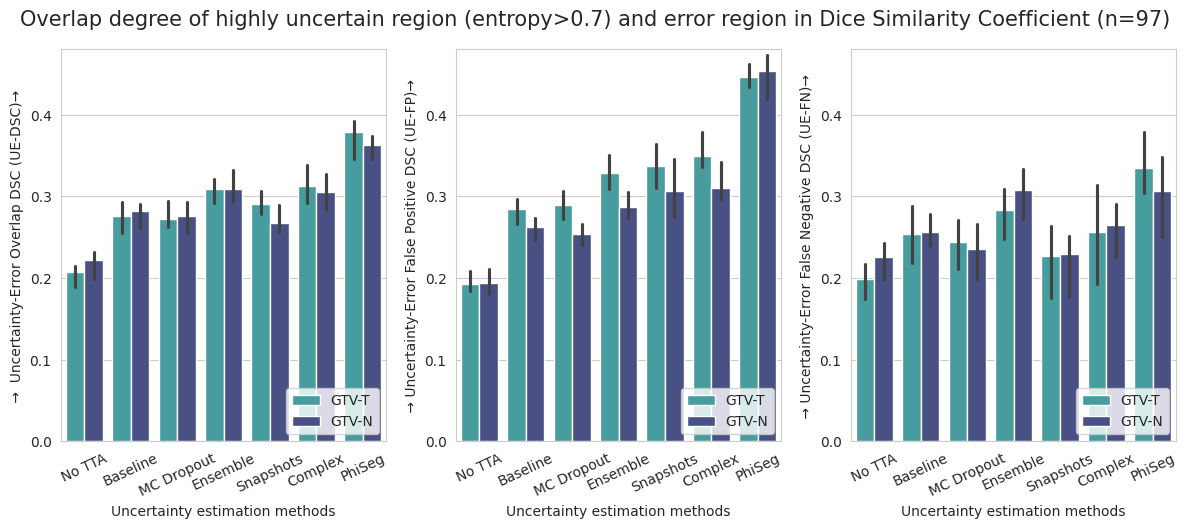

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

def add_median_ci_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.median() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}'.lstrip('0'), ha='center', va='center',  color='white', fontweight='bold', fontsize=8)
                       
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=median.get_color()),
            path_effects.Normal(),
        ])

fig.suptitle('Overlap degree of highly uncertain region (entropy>0.7) and error region in Dice Similarity Coefficient (n=97)', size=15)
#fig.text(0.02, 0.9, 'C', size=30)

sns.set_style("whitegrid")
exp= 'UED'
y_value = df_ued_all_internal[exp].astype({exp: float})
sns.barplot(ax = axes[0], x=df_ued_all_internal["Uncertainty estimation methods"], y=y_value,  estimator='median',
             seed=42, n_boot=10000, errorbar=('ci', 95), hue =df_ued_all_internal["GTV"], palette="mako_r").set( ylabel=f' \u2192  Uncertainty-Error Overlap DSC (UE-DSC)\u2192 ')
exp= 'FPD'
y_value = df_ued_all_internal[exp].astype({exp: float})
sns.barplot(ax = axes[1], x=df_ued_all_internal["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =df_ued_all_internal["GTV"], palette="mako_r").set( ylabel=' \u2192 Uncertainty-Error False Positive DSC (UE-FP)\u2192 ')

exp= 'FND'
y_value = df_ued_all_internal[exp].astype({exp: float})
sns.barplot(ax = axes[2], x=df_ued_all_internal["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =df_ued_all_internal["GTV"], palette="mako_r").set( ylabel=' \u2192 Uncertainty-Error False Negative DSC (UE-FN)\u2192 ')

axes[0].set_ylim(0, 0.48) 
axes[1].set_ylim(0, 0.48) 
axes[2].set_ylim(0, 0.48) 
# for p in axes[0].patches:
#     text = axes[0].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    size=8, color='white', fontweight='bold',
#                    xytext = (0, 0), 
#                    textcoords = 'offset points')
#     text.set_path_effects([
#                 path_effects.Stroke(linewidth=1.5, foreground='black'),
#                 path_effects.Normal(),
#             ])
    
# for p in axes[1].patches:
#     text = axes[1].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    size=8, color='white', fontweight='bold',
#                    xytext = (0, 0), 
#                    textcoords = 'offset points')
#     text.set_path_effects([
#                 path_effects.Stroke(linewidth=1.5, foreground='black'),
#                 path_effects.Normal(),
#             ])
    
# for p in axes[2].patches:
#     text = axes[2].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
#                    (p.get_x() + p.get_width() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    size=8, color='white', fontweight='bold',
#                    xytext = (0, 0), 
#                    textcoords = 'offset points')
#     text.set_path_effects([
#                 path_effects.Stroke(linewidth=1.5, foreground='black'),
#                 path_effects.Normal(),
#             ])
fig.tight_layout()
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
axes[2].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
plt.savefig('../figures/figure2_bar.png', dpi = 500, bbox_inches='tight')
plt.savefig( '../figures/figure2_bar.svg', format = 'svg', bbox_inches='tight')


Zero counts in UED: 50
Zero counts in FPD: 3
Zero counts in FND: 135


In [4]:
df_ued_all_internal[(df_ued_all_internal['PatientID']=='HNCDL_628') & (df_ued_all_internal["Uncertainty estimation methods"] == 'Complex')]

,PatientID,UED,UED_volume,UED_th,FND,FND_volume,FND_th,FPD,FPD_volume,FPD_th,GTV,Ucertainty estimation methods
1044,HNCDL_628,0.354373,14684,7,0.202613,9837,7,0.461363,4847,7,GTV-T,Complex
1141,HNCDL_628,0.231213,3298,7,0.316524,2374,7,0.164618,924,7,GTV-N,Complex


In [5]:
df_ued_all_internal[(df_ued_all_internal['PatientID']=='HNCDL_095') & (df_ued_all_internal["Uncertainty estimation methods"] == 'Complex')]

,PatientID,UED,UED_volume,UED_th,FND,FND_volume,FND_th,FPD,FPD_volume,FPD_th,GTV,Ucertainty estimation methods
985,HNCDL_095,0.362427,19817,7,0.18865,16511,7,0.991453,3306,7,GTV-T,Complex
1082,HNCDL_095,0.319015,1517,7,0.333437,1211,7,0.215247,306,7,GTV-N,Complex


/tmp/ipykernel_2673088/631726926.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
/tmp/ipykernel_2673088/631726926.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
/tmp/ipykernel_2673088/631726926.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[1].get_xticklabels(),rotation=25)


[Text(0, 0, 'No TTA'),
 Text(1, 0, 'Baseline'),
 Text(2, 0, 'MC Dropout'),
 Text(3, 0, 'Ensemble'),
 Text(4, 0, 'Snapshots'),
 Text(5, 0, 'Complex'),
 Text(6, 0, 'PhiSeg')]

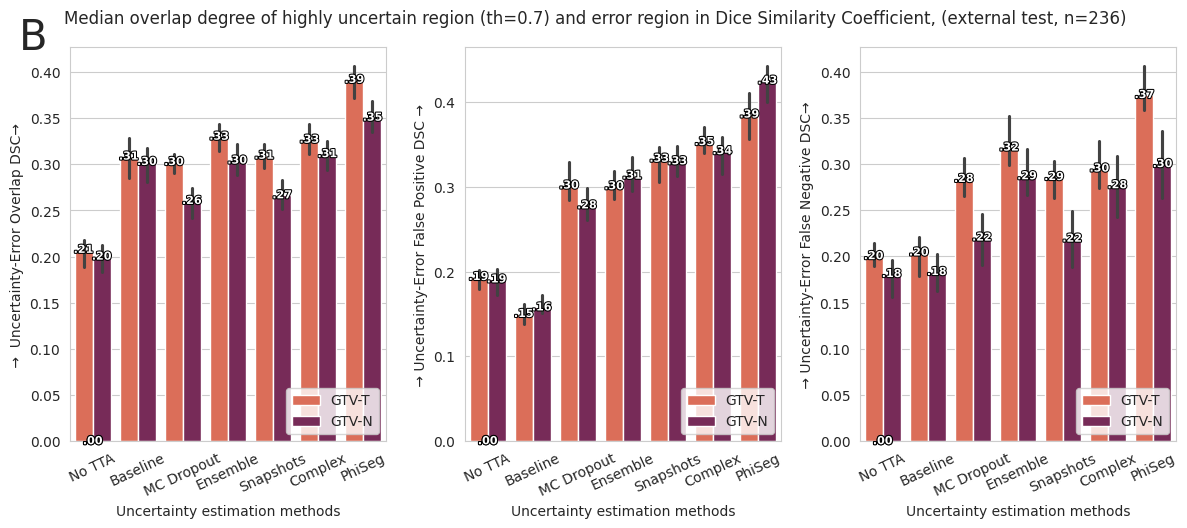

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

fig.suptitle('Median overlap degree of highly uncertain region (th=0.7) and error region in Dice Similarity Coefficient, (external test, n=236)', size=12)

fig.text(0.02, 0.9, 'B', size=30)
sns.set_style("whitegrid")
exp= 'UED'
y_value = df_ued_all_external[exp].astype({exp: float})
sns.barplot(ax = axes[0], x=df_ued_all_external["Uncertainty estimation methods"], y=y_value,  estimator='median',
             seed=42, n_boot=10000, errorbar=('ci', 95), hue =df_ued_all_external["GTV"], palette="rocket_r").set( ylabel=f' \u2192  Uncertainty-Error Overlap DSC\u2192 ')
exp= 'FPD'
y_value = df_ued_all_external[exp].astype({exp: float})
sns.barplot(ax = axes[1], x=df_ued_all_external["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =df_ued_all_external["GTV"], palette="rocket_r").set( ylabel=' \u2192 Uncertainty-Error False Positive DSC \u2192 ')

exp= 'FND'
y_value = df_ued_all_external[exp].astype({exp: float})
sns.barplot(ax = axes[2], x=df_ued_all_external["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =df_ued_all_external["GTV"], palette="rocket_r").set( ylabel=' \u2192 Uncertainty-Error False Negative DSC\u2192 ')


for p in axes[0].patches:
    text = axes[0].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[1].patches:
    text = axes[1].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[2].patches:
    text = axes[2].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
fig.tight_layout()
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[2].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
axes[2].set_xticklabels(axes[1].get_xticklabels(),rotation=25)


# compare between different methods


In [7]:
def find_best_t(study):
    sum_path = os.path.join(study, 'uregion_summary.json')
    study_name = os.path.basename(study)
    best_GTV_T = 0
    best_GTV_N = 0

    best_GTV_T_s =None
    best_GTV_N_s =None

    with open(sum_path) as file:
        json_dict = json.load(file)
    for key in json_dict.keys():
        cur_t = (json_dict[key]['GTV-T']['UED'])
        cur_n = (json_dict[key]['GTV-N']['UED'])
        
        if best_GTV_T < cur_t:
            best_GTV_T = cur_t
            best_GTV_T_s = key

        if best_GTV_N < cur_n:
            best_GTV_N = cur_n
            best_GTV_N_s = key
    print(f'{study_name} - best GTVT S: {best_GTV_T_s}, UED: {best_GTV_T}, Best GTVN S: {best_GTV_N_s}, UED: {best_GTV_N}')
    bset_t_study = os.path.join(study,  str(best_GTV_T_s), 'GTV-T')
    bset_n_study = os.path.join(study, str(best_GTV_N_s), 'GTV-N')

    return bset_t_study, bset_n_study

In [8]:


## directorys for main internal probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"

studies = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAP,'f01234_tta')

]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots',"Complex", 'PhiSeg' ]
for i, study in enumerate(studies):
    gtvt_calib, gtvn_calib  = reconstruct_calib_df_from_json(study)
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    study = study.replace("prob_maps", "u_regions")

    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T
    df_cal_t = pd.DataFrame.from_dict(gtvt_calib).T
    df_cal_n = pd.DataFrame.from_dict(gtvn_calib).T


    dft = pd.concat([df_seg_t,df_cal_t], axis = 1)
    dfn = pd.concat([df_seg_n,df_cal_n], axis = 1)
    dft['Uncertainty estimation methods'] = groups[i]
    dfn['Uncertainty estimation methods'] = groups[i]
    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all = dft
        dfn_all = dfn
    else:
        dft_all = pd.concat([dft_all, dft])
        dfn_all = pd.concat([dfn_all, dfn])


all_seg_carl_internal = pd.concat([dft_all, dfn_all])
all_seg_carl_internal= all_seg_carl_internal.reset_index(drop=True)

## directorys for external probability maps 

DROP2_PMAPS_EXT="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
NNUNET_PMAPS_EXT="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_PMAPS_EXT="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_GAMM_PMAPS_EXT="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"

studies = [
join(NNUNET_PMAPS_EXT,'f0'), #X1
join(NNUNET_PMAPS_EXT,'f0_tta'),#X8
join(DROP2_PMAPS_EXT,'f0_mc10_tta') #X80
,join(NNUNET_PMAPS_EXT,'f01234_tta') #X40
#,join(NNUNET_PMAPS_EXT,'f012456_tta')
,join(DROP2_PMAPS_EXT,'f0_tta_snap') #X40
,join(DROP2_PMAPS_EXT,'f01234_mc10_tta_snap') #X2000
,join(PH_PMAPS_EXT,'f01234_tta') #X40

]

groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots',"Complex", 'PhiSeg' ]
for i, study in enumerate(studies):
    gtvt_calib, gtvn_calib  = reconstruct_calib_df_from_json(study)
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    study = study.replace("prob_maps", "u_regions")

    #best_t_gtvt_study, best_t_gtvn_study = find_best_t(study)

    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T
    df_cal_t = pd.DataFrame.from_dict(gtvt_calib).T
    df_cal_n = pd.DataFrame.from_dict(gtvn_calib).T


    dft = pd.concat([df_seg_t,df_cal_t], axis = 1)
    dfn = pd.concat([df_seg_n,df_cal_n], axis = 1)
    dft['Uncertainty estimation methods'] = groups[i]
    dfn['Uncertainty estimation methods'] = groups[i]
    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all = dft
        dfn_all = dfn
    else:
        dft_all = pd.concat([dft_all, dft])
        dfn_all = pd.concat([dfn_all, dfn])


all_seg_carl_external = pd.concat([dft_all, dfn_all])
all_seg_carl_external= all_seg_carl_external.reset_index(drop=True)

[Text(0, 0, 'No TTA'),
 Text(1, 0, 'Baseline'),
 Text(2, 0, 'MC Dropout'),
 Text(3, 0, 'Ensemble'),
 Text(4, 0, 'Snapshots'),
 Text(5, 0, 'Complex'),
 Text(6, 0, 'PhiSeg')]

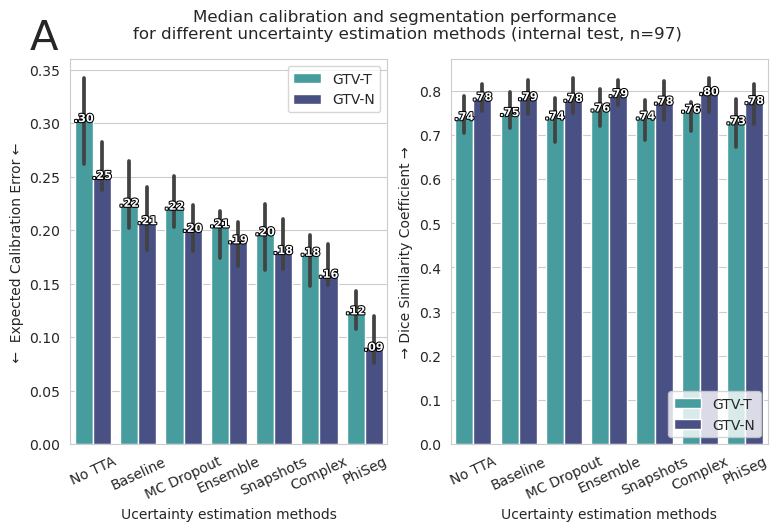

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=False)

def add_median_ci_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}'.lstrip('0'), ha='center', va='center',  color='white', fontweight='bold', fontsize=8)
                       
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=median.get_color()),
            path_effects.Normal(),
        ])

fig.suptitle('Median calibration and segmentation performance \nfor different Uncertainty estimation methods (internal test, n=97)', size=12)
fig.text(0.08, 0.9, 'A', size=30)

sns.set_style("whitegrid")
exp= 'Expected Calibration Error'
y_value = all_seg_carl_internal[exp].astype({exp: float})
sns.barplot(ax = axes[0], x=all_seg_carl_internal["Uncertainty estimation methods"], y=y_value,  estimator='median',
             seed=42, n_boot=10000, errorbar=('ci', 95), hue =all_seg_carl_internal["GTV"], palette="mako_r").set( ylabel=f' \u2190  {exp} \u2190 ')
exp= 'DSC'
y_value = all_seg_carl_internal[exp].astype({exp: float})
sns.barplot(ax = axes[1], x=all_seg_carl_internal["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =all_seg_carl_internal["GTV"], palette="mako_r").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')
#sns.stripplot(ax = axes[2],x=all_data["Uncertainty estimation methods"], y=y_value,  hue =all_data["GTV"], jitter=True,   dodge=True,  palette="mako", alpha=0.1, marker='o', legend=False)


for p in axes[0].patches:
    text = axes[0].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[1].patches:
    text = axes[1].annotate(str(format(p.get_height(), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
axes[0].legend(loc='upper right')
axes[1].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
# fig.savefig("figures/fig_2a_bar.png", dpi=300) 
# fig.savefig("fig_2a_bar.svg") 

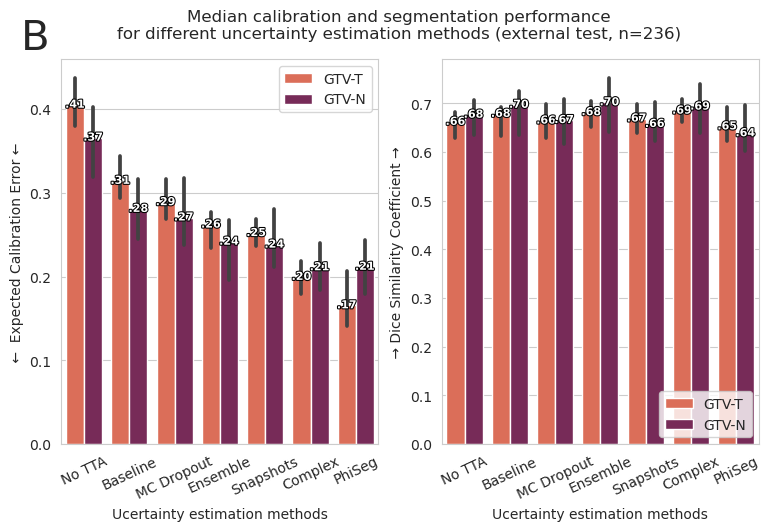

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=False)

fig.suptitle('Median calibration and segmentation performance\nfor different uncertainty estimation methods (external test, n=236)', size=12)
fig.text(0.08, 0.9, 'B', size=30)

sns.set_style("whitegrid")
exp= 'Expected Calibration Error'
y_value = all_seg_carl_external[exp].astype({exp: float})
sns.barplot(ax = axes[0], x=all_seg_carl_external["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =all_seg_carl_external["GTV"], palette="rocket_r").set( ylabel=f' \u2190  {exp} \u2190 ')
exp= 'DSC'
y_value = all_seg_carl_external[exp].astype({exp: float})
sns.barplot(ax = axes[1], x=all_seg_carl_external["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =all_seg_carl_external["GTV"], palette="rocket_r").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')

#sns.stripplot(ax = axes[2],x=all_data["Uncertainty estimation methods"], y=y_value,  hue =all_data["GTV"], jitter=True,   dodge=True,  palette="mako", alpha=0.1, marker='o', legend=False)

for p in axes[0].patches:
    text = axes[0].annotate(str(format(np.round(p.get_height(),2), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
    
for p in axes[1].patches:
    text = axes[1].annotate(str(format(np.round(p.get_height(),2), '.2f')).lstrip('0'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=8, color='white', fontweight='bold',
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    text.set_path_effects([
                path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal(),
            ])
axes[0].legend(loc='upper right')
axes[1].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
plt.show()
# fig.savefig("figures/fig_2b_bar.png", dpi=300) 
# fig.savefig("figures/fig_2b_bar.svg") 

### Plot for paper

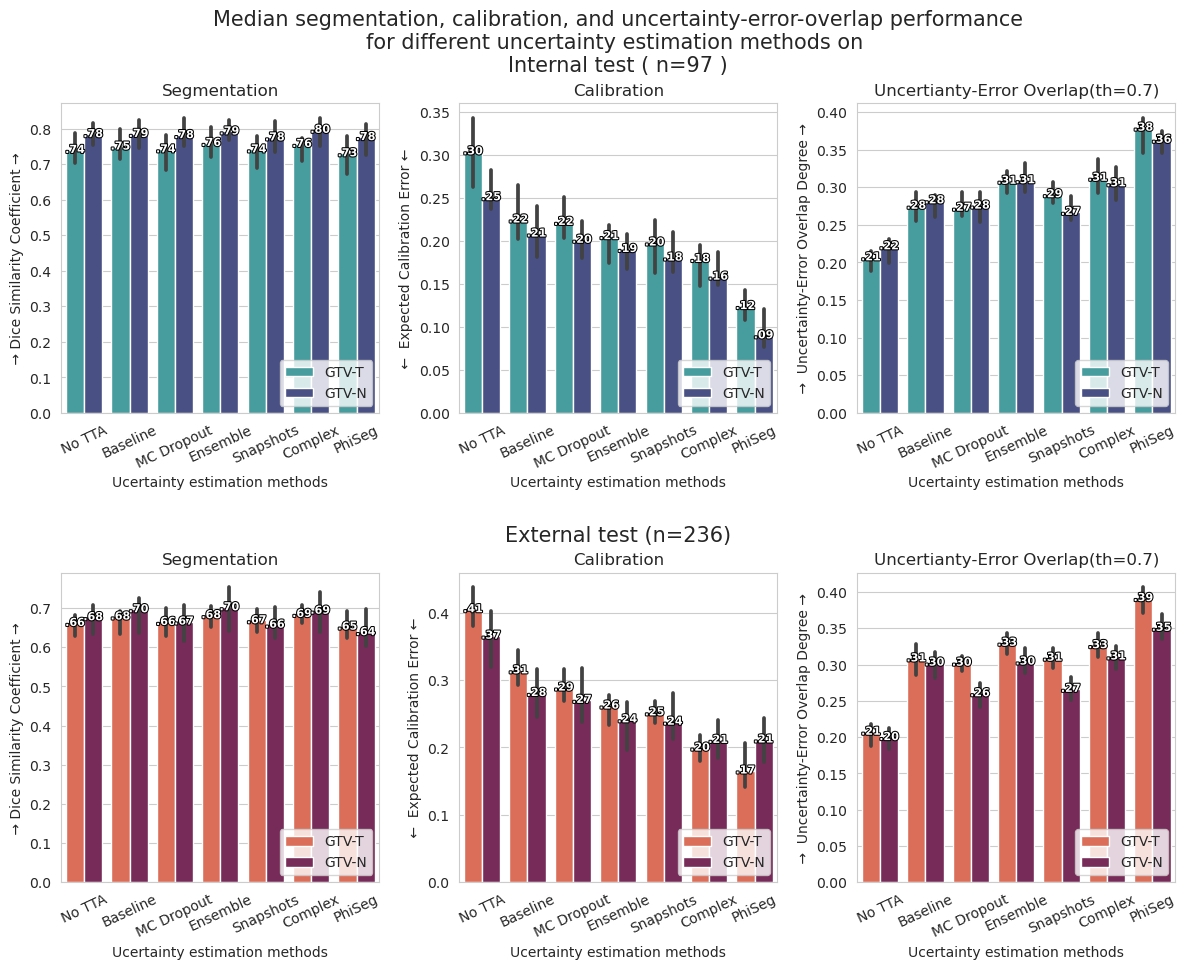

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n',size=15)#, fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

# create 3x1 subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 10), sharey=False)
#fig.suptitle('Figure title')

grid = plt.GridSpec(2, 3)

exp= 'DSC'
y_value = all_seg_carl_internal[exp].astype({exp: float})
sns.barplot(ax = axs[0][0], x=all_seg_carl_internal["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =all_seg_carl_internal["GTV"], palette="mako_r").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')

exp= 'Expected Calibration Error'
y_value = all_seg_carl_internal[exp].astype({exp: float})
sns.barplot(ax = axs[0][1], x=all_seg_carl_internal["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =all_seg_carl_internal["GTV"], palette="mako_r").set( ylabel=f' \u2190  {exp} \u2190 ')

exp= 'UED'
y_value = df_ued_all_internal[exp].astype({exp: float})
sns.barplot(ax = axs[0][2], x=df_ued_all_internal["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =df_ued_all_internal["GTV"], palette="mako_r").set( ylabel=f' \u2192  Uncertainty-Error Overlap Degree \u2192 ')

#sns.stripplot(ax = axes[2],x=all_data["Uncertainty estimation methods"], y=y_value,  hue =all_data["GTV"], jitter=True,   dodge=True,  palette="mako", alpha=0.1, marker='o', legend=False)

exp= 'DSC'
y_value = all_seg_carl_external[exp].astype({exp: float})
sns.barplot(ax = axs[1][0], x=all_seg_carl_external["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =all_seg_carl_external["GTV"], palette="rocket_r").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')

exp= 'Expected Calibration Error'
y_value = all_seg_carl_external[exp].astype({exp: float})
sns.barplot(ax = axs[1][1], x=all_seg_carl_external["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =all_seg_carl_external["GTV"], palette="rocket_r").set( ylabel=f' \u2190  {exp} \u2190 ')

exp= 'UED'
y_value = df_ued_all_external[exp].astype({exp: float})
sns.barplot(ax = axs[1][2], x=df_ued_all_external["Uncertainty estimation methods"], y=y_value,  estimator='median', 
            seed=42, n_boot=10000, errorbar=('ci', 95), hue =df_ued_all_external["GTV"], palette="rocket_r").set( ylabel=f' \u2192  Uncertainty-Error Overlap Degree \u2192 ')

create_subtitle(fig, grid[0, ::], 'Median segmentation, calibration, and uncertainty-error-overlap performance\nfor different uncertainty estimation methods on \nInternal test ( n=97 )')
create_subtitle(fig, grid[1, ::], 'External test (n=236)')

#for 
subsub_title_list = ['Segmentation', 'Calibration','Uncertianty-Error Overlap(th=0.7)', 'Segmentation', 'Calibration','Uncertianty-Error Overlap(th=0.7)']
for i, ax in enumerate(axs.flatten()):

    ax.set_title(subsub_title_list[i])
    for p in ax.patches:
        text = ax.annotate(str(format(np.round(p.get_height(),2), '.2f')).lstrip('0'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    size=8, color='white', fontweight='bold',
                    xytext = (0, 0), 
                    textcoords = 'offset points')
        text.set_path_effects([
                    path_effects.Stroke(linewidth=1.5, foreground='black'),
                    path_effects.Normal(),
                ])

    
    ax.legend(loc='lower right')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=25)

# fig.text(0.035, 0.855,'A', size=15, fontweight='semibold')
# fig.text(0.37, 0.855, 'B', size=15, fontweight='semibold')
# fig.text(0.7,  0.855, 'C', size=15, fontweight='semibold')
# fig.text(0.035,0.38,'E', size=15, fontweight='semibold')
# fig.text(0.37, 0.38, 'F', size=15, fontweight='semibold')
# fig.text(0.7,  0.38, 'G', size=15, fontweight='semibold')
fig.tight_layout()
plt.show()
fig.savefig("figures/fig_2b_bar.png", dpi=300) 
fig.savefig("figures/fig_2b_bar.svg") 

# False target Correction using uncertainty maps 

In [12]:
## directorys for internal  probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"

studies = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAPS,'f01234_tta')
]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots', "Complex" ,'PhiSeg']
for i, study in enumerate(studies):
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T

    study = study.replace("prob_maps", "repaired")
    gtvt_seg_correct, gtvn_seg_correct  = reconstruct_seg_df_from_json(study)
    df_seg_t_correct = pd.DataFrame.from_dict(gtvt_seg_correct).T
    df_seg_n_correct = pd.DataFrame.from_dict(gtvn_seg_correct).T
    df_seg_t_correct['GTV'] = 'GTV-T_corrected'
    df_seg_n_correct['GTV'] = 'GTV-N_corrected'

    dft = pd.concat([df_seg_t,df_seg_t_correct], axis = 0)
    dfn = pd.concat([df_seg_n,df_seg_n_correct], axis = 0)

    dft['Uncertainty estimation methods'] = groups[i]
    dfn['Uncertainty estimation methods'] = groups[i]

    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all_correct = dft
        dfn_all_correct = dfn
    else:
        dft_all_correct = pd.concat([dft_all_correct, dft])
        dfn_all_correct = pd.concat([dfn_all_correct, dfn])


all_data_correct_internal = pd.concat([dft_all_correct, dfn_all_correct])
all_data_correct_internal= all_data_correct_internal.reset_index(drop=False)



## directorys for external probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"

studies = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAPS,'f01234_tta')
]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots', "Complex" ,'PhiSeg']
for i, study in enumerate(studies):
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T

    study = study.replace("prob_maps", "repaired")
    gtvt_seg_correct, gtvn_seg_correct  = reconstruct_seg_df_from_json(study)
    df_seg_t_correct = pd.DataFrame.from_dict(gtvt_seg_correct).T
    df_seg_n_correct = pd.DataFrame.from_dict(gtvn_seg_correct).T
    df_seg_t_correct['GTV'] = 'GTV-T_corrected'
    df_seg_n_correct['GTV'] = 'GTV-N_corrected'

    dft = pd.concat([df_seg_t,df_seg_t_correct], axis = 0)
    dfn = pd.concat([df_seg_n,df_seg_n_correct], axis = 0)

    dft['Uncertainty estimation methods'] = groups[i]
    dfn['Uncertainty estimation methods'] = groups[i]

    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all_correct = dft
        dfn_all_correct = dfn
    else:
        dft_all_correct = pd.concat([dft_all_correct, dft])
        dfn_all_correct = pd.concat([dfn_all_correct, dfn])


all_data_correct_external = pd.concat([dft_all_correct, dfn_all_correct])
all_data_correct_external= all_data_correct_external.reset_index(drop=False)

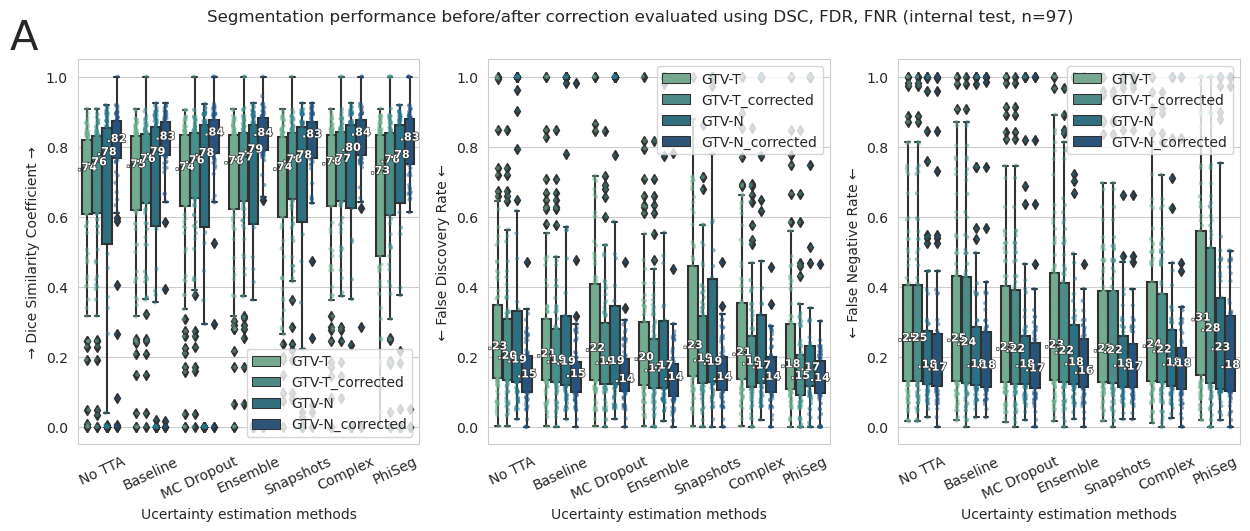

In [13]:

def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = np.round(x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y,2)
        text = ax.text(x, y, f'{value:{fmt}}'.lstrip('0'), ha='center', va='center',  color='white', fontweight='bold', fontsize=8)
                       
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=1, foreground=median.get_color()),
            path_effects.Normal(),
        ])

all_data_correct_internal.replace([np.inf, -np.inf], np.nan, inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
sns.set_style("whitegrid")
fig.suptitle('Segmentation performance before/after correction evaluated using DSC, FDR, FNR (internal test, n=97)' , size=12)
fig.text(0.08, 0.9, 'A', size=30)


exp= 'DSC'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[0],x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[0], x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')
add_median_labels(axes[0])
#
exp= 'False Discovery Rate'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[1],x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[1], x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest" ).set( ylabel=' \u2190 False Discovery Rate \u2190 ')
add_median_labels(axes[1])

exp= 'False Negative Rate'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[2],x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[2], x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest" ).set( ylabel=' \u2190 False Negative Rate \u2190 ')
add_median_labels(axes[2])
#
axes[0].legend(loc='lower right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=25)
plt.show()
# fig.savefig("figures/fig_4a_box.png", dpi=300) 
# fig.savefig("figures/fig_4a_box.svg") 

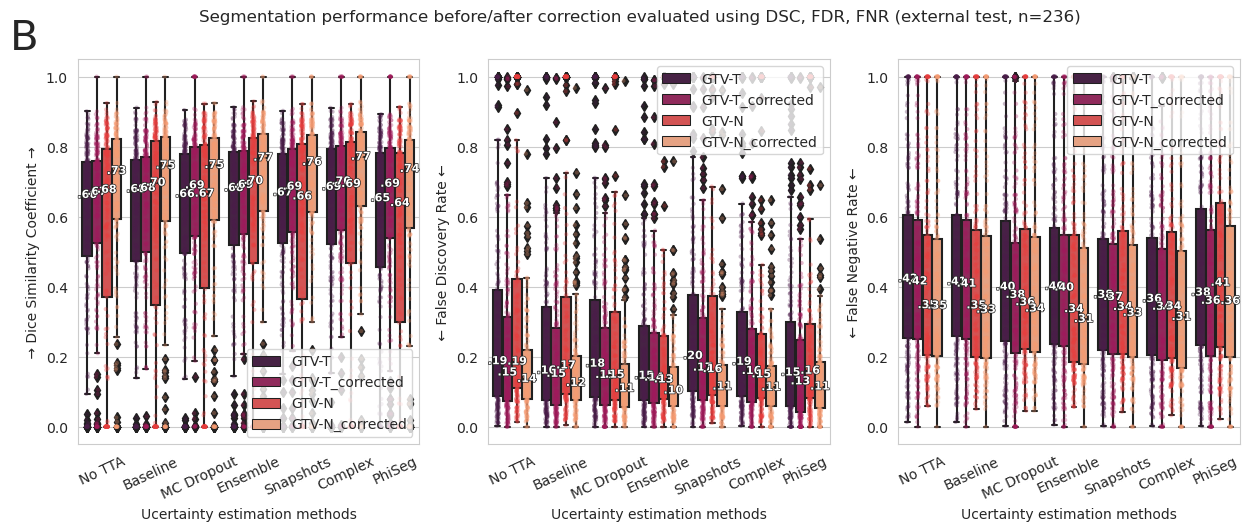

In [14]:


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
sns.set_style("whitegrid")
fig.suptitle('Segmentation performance before/after correction evaluated using DSC, FDR, FNR (external test, n=236)' , size=12)
fig.text(0.08, 0.9, 'B', size=30)

all_data_correct_external.replace([np.inf, -np.inf], np.nan, inplace=True)

exp= 'DSC'
y_value = all_data_correct_external[exp].astype({exp: float})
sns.stripplot(ax = axes[0],x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,   dodge=True,  palette="rocket", size = 3, alpha=0.3, marker='o', legend=False)
sns.boxplot(ax = axes[0], x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')
add_median_labels(axes[0])
exp= 'False Discovery Rate'
y_value = all_data_correct_external[exp].astype({exp: float})
sns.stripplot(ax = axes[1],x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,  dodge=True, palette="rocket",  size = 3, alpha=0.3, marker='o', legend=False)
sns.boxplot(ax = axes[1], x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2190 False Discovery Rate \u2190 ')
add_median_labels(axes[1])
exp= 'False Negative Rate'
y_value = all_data_correct_external[exp].astype({exp: float})

sns.stripplot(ax = axes[2],x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,   dodge=True, palette="rocket",  alpha=0.3, size = 3, marker='o', legend=False)
sns.boxplot(ax = axes[2], x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2190 False Negative Rate \u2190 ')

add_median_labels(axes[2])
axes[0].legend(loc='lower right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=25)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=25)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=25)
plt.show()
# fig.savefig("figures/fig_4b_box.png", dpi=300) 
# fig.savefig("figures/fig_4b_box.svg") 

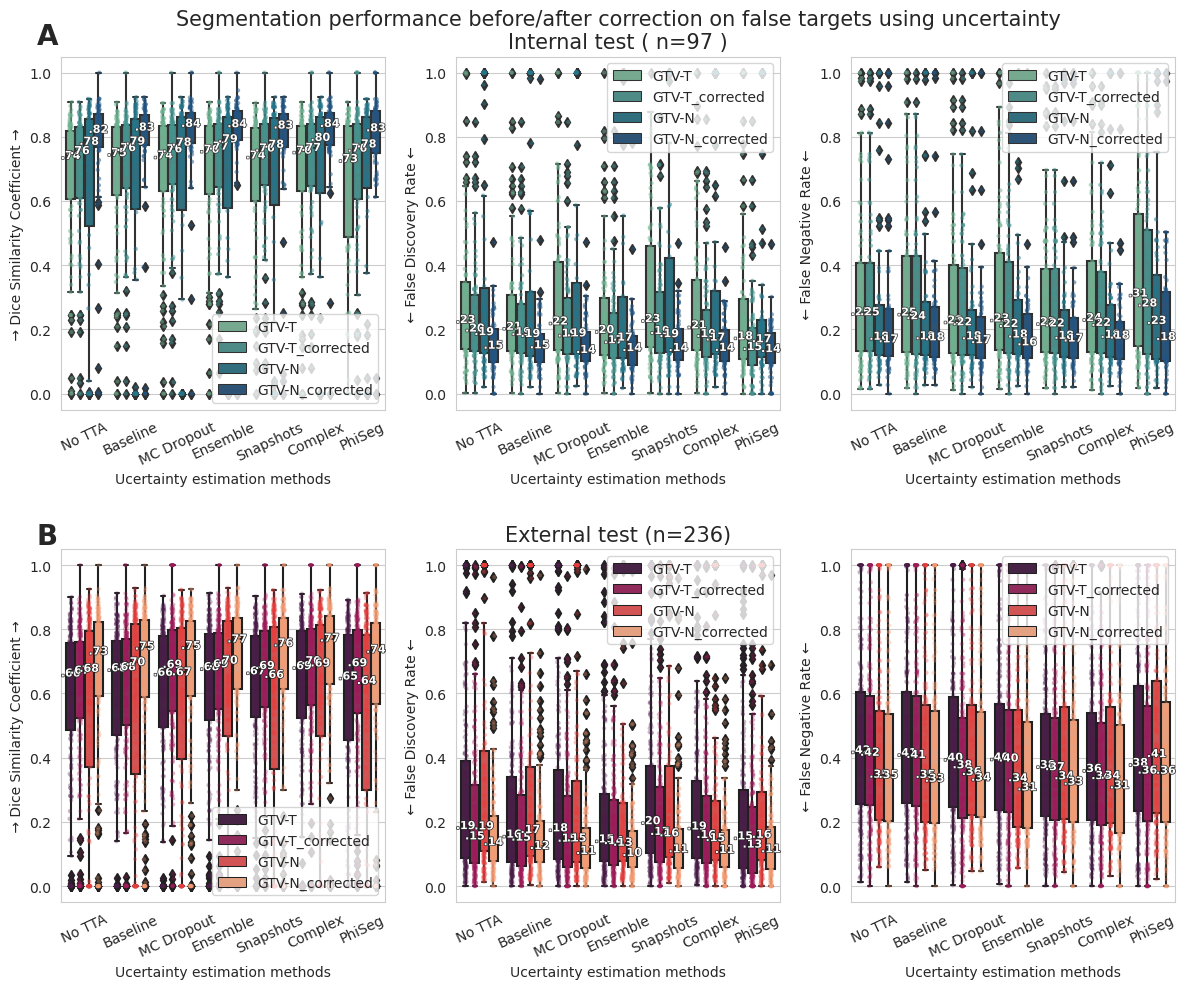

In [15]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}',size=15)#, fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
# create 3x1 subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=False)
#fig.suptitle('Figure title')
grid = plt.GridSpec(2, 3)

exp= 'DSC'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[0][0],x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[0][0], x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')
add_median_labels(axes[0][0])
#
exp= 'False Discovery Rate'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[0][1],x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[0][1], x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest" ).set( ylabel=' \u2190 False Discovery Rate \u2190 ')
add_median_labels(axes[0][1])

exp= 'False Negative Rate'
y_value = all_data_correct_internal[exp].astype({exp: float})
sns.stripplot(ax = axes[0][2],x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], jitter=True,   dodge=True,  palette="crest", size = 3, alpha=0.5, marker='o', legend=False)
sns.boxplot(ax = axes[0][2], x=all_data_correct_internal["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_internal["GTV"], palette="crest" ).set( ylabel=' \u2190 False Negative Rate \u2190 ')
add_median_labels(axes[0][2])

all_data_correct_external.replace([np.inf, -np.inf], np.nan, inplace=True)
exp= 'DSC'
y_value = all_data_correct_external[exp].astype({exp: float})
sns.stripplot(ax = axes[1][0],x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,   dodge=True,  palette="rocket", size = 3, alpha=0.3, marker='o', legend=False)
sns.boxplot(ax = axes[1][0], x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2192 Dice Similarity Coefficient \u2192 ')
add_median_labels(axes[1][0])
exp= 'False Discovery Rate'
y_value = all_data_correct_external[exp].astype({exp: float})
sns.stripplot(ax = axes[1][1],x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,  dodge=True, palette="rocket",  size = 3, alpha=0.3, marker='o', legend=False)
sns.boxplot(ax = axes[1][1], x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2190 False Discovery Rate \u2190 ')
add_median_labels(axes[1][1])
exp= 'False Negative Rate'
y_value = all_data_correct_external[exp].astype({exp: float})

sns.stripplot(ax = axes[1][2],x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], jitter=True,   dodge=True, palette="rocket",  alpha=0.3, size = 3, marker='o', legend=False)
sns.boxplot(ax = axes[1][2], x=all_data_correct_external["Uncertainty estimation methods"], y=y_value,  hue =all_data_correct_external["GTV"], palette="rocket").set( ylabel=' \u2190 False Negative Rate \u2190 ')
add_median_labels(axes[1][2])

create_subtitle(fig, grid[0, ::], 'Segmentation performance before/after correction on false targets using uncertainty\nInternal test ( n=97 )')
create_subtitle(fig, grid[1, ::], '\nExternal test (n=236)')

subsub_title_list = ['', '','', '', '','']
for i, ax in enumerate(axes.flatten()):
    
    ax.set_title(subsub_title_list[i])
    # for p in ax.patches:
    #     text = ax.annotate(str(format(np.round(p.get_height(),2), '.2f')).lstrip('0'), 
    #                 (p.get_x() + p.get_width() / 2., p.get_height()), 
    #                 ha = 'center', va = 'center', 
    #                 size=8, color='white', fontweight='bold',
    #                 xytext = (0, 0), 
    #                 textcoords = 'offset points')
    #     text.set_path_effects([
    #                 path_effects.Stroke(linewidth=1.5, foreground='black'),
    #                 path_effects.Normal(),
    #             ])
    #ax.legend(loc='lower right')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=25)

# fig.text(0.035, 0.855,'A', size=15, fontweight='semibold')
# fig.text(0.37, 0.855, 'B', size=15, fontweight='semibold')
# fig.text(0.7,  0.855, 'C', size=15, fontweight='semibold')
# fig.text(0.035,0.38,'E', size=15, fontweight='semibold')
# fig.text(0.37, 0.38, 'F', size=15, fontweight='semibold')
# fig.text(0.7,  0.38, 'G', size=15, fontweight='semibold')
fig.tight_layout()

fig.text(0.035, 0.95,'A', size=20, fontweight='semibold')
fig.text(0.035, 0.45, 'B', size=20, fontweight='semibold')

axes[0][0].legend(loc='lower right')
axes[0][1].legend(loc='upper right')
axes[0][2].legend(loc='upper right')

axes[1][0].legend(loc='lower right')
axes[1][1].legend(loc='upper right')
axes[1][2].legend(loc='upper right')

# axes[1][0].set_xticklabels(axes[1][0].get_xticklabels(),rotation=25)
# axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(),rotation=25)
# axes[1][2].set_xticklabels(axes[1][2].get_xticklabels(),rotation=25)


plt.show()
fig.savefig("figures/fig_3_box.png", dpi=300) 
fig.savefig("figures/fig_3_box.svg") 



### wilcoxon paired test for ensemble study

In [16]:
## directorys for internal  probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"

studies = [
join(NNUNET_PMAPS,'f0'),
join(NNUNET_PMAPS,'f0_tta'),
join(DROP2_PMAPS,'f0_mc10_tta')
,join(NNUNET_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f012456_tta')
,join(DROP2_PMAPS,'f0_tta_snap')
,join(DROP2_PMAPS,'f01234_mc10_tta_snap')
,join(PH_PMAPS,'f01234_tta')
#,join(NNUNET_PMAPS,'f0123456789_tta')
]
#,join(PH_GAMM_PMAP,'f0_tta')]


groups = ['No TTA','Baseline', 'MC Dropout','Ensemble','Snapshots', "Complex" ,'PhiSeg'] #, 'Ensemble10']
for i, study in enumerate(studies):
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    df_seg_t = pd.DataFrame.from_dict(gtvt_seg).T
    df_seg_n = pd.DataFrame.from_dict(gtvn_seg).T

    study = study.replace("prob_maps", "repaired")
    gtvt_seg_correct, gtvn_seg_correct  = reconstruct_seg_df_from_json(study)
    df_seg_t_correct = pd.DataFrame.from_dict(gtvt_seg_correct).T
    df_seg_n_correct = pd.DataFrame.from_dict(gtvn_seg_correct).T
    df_seg_t_correct['GTV'] = 'GTV-T_corrected'
    df_seg_n_correct['GTV'] = 'GTV-N_corrected'

    dft = pd.concat([df_seg_t,df_seg_t_correct], axis = 0)
    dfn = pd.concat([df_seg_n,df_seg_n_correct], axis = 0)

    dft['Uncertainty estimation methods'] = groups[i]
    dfn['Uncertainty estimation methods'] = groups[i]

    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)

    if i == 0:
        dft_all_correct = dft
        dfn_all_correct = dfn
    else:
        dft_all_correct = pd.concat([dft_all_correct, dft])
        dfn_all_correct = pd.concat([dfn_all_correct, dfn])


all_data_correct_internal = pd.concat([dft_all_correct, dfn_all_correct])
all_data_correct_internal= all_data_correct_internal.reset_index(drop=False)

from scipy.stats import wilcoxon
test_data = all_data_correct_internal[(all_data_correct_internal["Uncertainty estimation methods"]=='Ensemble') & ((all_data_correct_internal["GTV"]=="GTV-T") | (all_data_correct_internal["GTV"]=="GTV-T_corrected"))]

def calcualte_test(x, y, method = wilcoxon):
    # method could also be pearsonr
    nas = np.logical_or(np.isnan(x), np.isnan(y)) # remove nan
    return method(x[~nas], y[~nas])

exp= 'DSC'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-T"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-T_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")
exp= 'HD95 (mm)'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-T"][exp].astype({exp: float})

print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-T_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")
exp= 'Mean Surface Distance (mm)'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-T"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-T_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")

test_data = all_data_correct_internal[(all_data_correct_internal["Uncertainty estimation methods"]=='Ensemble') & ((all_data_correct_internal["GTV"]=="GTV-N") | (all_data_correct_internal["GTV"]=="GTV-N_corrected"))]
print("----------------------")
print("--------GTV-N--------------")
print("----------------------")
exp= 'DSC'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-N"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-N_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")

exp= 'HD95 (mm)'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-N"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-N_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))

print("----------------------")
exp= 'Mean Surface Distance (mm)'
ensemble_y_value_before = test_data[test_data["GTV"]=="GTV-N"][exp].astype({exp: float})
print("before correction:", ensemble_y_value_before.mean(), ensemble_y_value_before.median())
ensemble_y_value_after = test_data[test_data["GTV"]=="GTV-N_corrected"][exp].astype({exp: float})
print("after correction:", ensemble_y_value_after.mean(), ensemble_y_value_after.median())
print(calcualte_test(ensemble_y_value_before.values,ensemble_y_value_after.values))
print("----------------------")

before correction: 0.6871486182374886 0.7596214796703794
after correction: 0.7176068550834097 0.7693222354340071
WilcoxonResult(statistic=20.0, pvalue=0.00020362581052161218)
----------------------
before correction: 11.651877577438645 6.0
after correction: 7.828251894674402 5.385164807134504
WilcoxonResult(statistic=12.0, pvalue=0.0005167151238567522)
----------------------
before correction: 3.4822879913069316 1.3336791033384265
after correction: 1.5924754774737926 1.2582726586131356
WilcoxonResult(statistic=14.0, pvalue=0.0006806104529480628)
----------------------
----------------------
--------GTV-N--------------
----------------------
before correction: 0.6387419555467178 0.7920823216570166
after correction: 0.7925228557087857 0.839128264847779
WilcoxonResult(statistic=0.0, pvalue=2.4770276393652366e-07)
----------------------
before correction: 20.247616943524143 5.830951894845301
after correction: 5.810394621252775 3.0
WilcoxonResult(statistic=0.0, pvalue=7.952884142692727e-07)

In [17]:
test_data

,index,PatientID,Accuracy,Mean Surface Distance (mm),DSC,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,HD95 (mm),...,Precision,Recall,Surface Dice 1mm,Surface Dice 2mm,Surface Dice 3mm,Volume (cc),Pred Volume (cc),True Negative Rate,GTV,Ucertainty estimation methods
1940,0,HNCDL_003,0.998904,1.491709,0.865603,0.180105,0.083293,0.000322,0.000778,5.830952,...,0.819895,0.916707,0.582719,0.7409,0.854778,86.21,96.39,0.999222,GTV-N,Ensemble
1941,1,HNCDL_007,0.999819,3.648548,0.813157,0.069711,0.277778,0.000151,0.000029,4.123106,...,0.930289,0.722222,0.720105,0.850167,0.9226,9.05,7.03,0.999971,GTV-N,Ensemble
1942,2,HNCDL_010,0.999584,NaN,0.0,1.0,NaN,0.0,0.000416,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,6.58,0.999584,GTV-N,Ensemble
1943,3,HNCDL_011,0.99972,1.633124,0.905598,0.121092,0.06604,0.000095,0.000185,4.0,...,0.878908,0.93396,0.852614,0.928022,0.945228,22.34,23.73,0.999815,GTV-N,Ensemble
1944,4,HNCDL_034,0.999503,1.249718,0.779095,0.25679,0.181378,0.000194,0.000303,3.741657,...,0.74321,0.818622,0.630025,0.826943,0.938495,20.22,22.28,0.999697,GTV-N,Ensemble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,189,HNCDL_868,0.99937,1.050575,0.761169,0.115867,0.331767,0.000499,0.000132,22.185579,...,0.884133,0.668233,0.573535,0.735809,0.833126,26.18,19.79,0.999868,GTV-N_corrected,Ensemble
2130,190,HNCDL_869,0.998935,1.369254,0.814118,0.077329,0.27158,0.000872,0.000196,8.124038,...,0.922671,0.72842,0.536765,0.713835,0.82992,51.12,40.36,0.999804,GTV-N_corrected,Ensemble
2131,191,HNCDL_876,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,GTV-N_corrected,Ensemble
2132,192,HNCDL_879,0.999703,0.900295,0.867591,0.135784,0.129007,0.000144,0.000153,2.790533,...,0.864216,0.870993,0.795381,0.933742,0.980206,19.0,19.15,0.999847,GTV-N_corrected,Ensemble


# Correlation between uncertainty and segmentation internal data

In [18]:
import SimpleITK as sitk
import numpy as np
from multiprocessing import Pool
from medpy.metric.binary import hd, asd
from scipy.ndimage import binary_erosion

def calcualte_target_entropy(arguments, only_seg_roi=False):
    th = 0.8
    umap_folder , seg_folder,  filename = arguments

    # create an dict for data storage

    seg_path = join(seg_folder, filename) 
    umap_path = join(umap_folder, filename.replace(".nii.gz", ".npz")) 
    pid = filename.replace(".nii.gz", "")
    
    
    seg = sitk.GetArrayFromImage(sitk.ReadImage(seg_path))
    umap = np.load(umap_path)['umap']

    resutl_list = []

    for target in range(1,3):

        entropy_results = {}
        entropy_results['PatientID'] = pid

        if target == 1:
            gtv = 'GTV-T'
            
        elif target == 2:
            gtv = 'GTV-N'

        # create an dict for each GTV
        entropy_results['GTV'] = gtv
    
        mask_seg = seg==target

        target_umap = umap[target]
        mask_umap = target_umap>th

        
        roi = mask_seg

        if not only_seg_roi:
            if np.sum(mask_seg) != 0:
                union_roi = (mask_seg + mask_umap)
                union_roi[union_roi>0] = 1
                roi = union_roi
        

        seg_entropy = target_umap * roi
        seg_entropy = seg_entropy[seg_entropy> 0] 



        if np.sum(mask_seg) == 0:
            # no segmentation made for this target (mostly GTV-N)
            entropy_results["Total Entropy"] = np.nan 
            entropy_results["Mean Entropy"] = np.nan 
            entropy_results["Entropy STD"] = np.nan 
            entropy_results["Entropy Volume"] = np.nan 
            entropy_results["Entropy Coefficient of Variation"] = np.nan 
            entropy_results["Logarithm Entropy Coefficient of Variation"] = np.nan 
            # entropy_results["Uncertainty-Segmentation Hausdorff distance"] = np.nan 
            # entropy_results["Uncertainty-Segmentation Mean Surface Distance"] = np.nan 

        else:
            # eros_seg  = binary_erosion(mask_seg, iterations=2).astype(int)
            # seg_line = mask_seg.astype(int) - eros_seg
            # e_hd  = hd(mask_umap, seg_line)
            # e_asd = asd(mask_umap, seg_line)
            entropy_mean = np.mean(seg_entropy) 
            entropy_std = np.std(seg_entropy) 
            entropy_results["Total Entropy"] = np.sum(seg_entropy)
            entropy_results["Mean Entropy"] = entropy_mean
            entropy_results["Entropy STD"] = entropy_std
            entropy_results["Entropy Volume"] = np.sum(roi) 
            entropy_results["Entropy Coefficient of Variation"] = entropy_std / (entropy_mean  + 1e-6) # + 1e-6 to avoid divide by 0
            entropy_results["Logarithm Entropy Coefficient of Variation"] = np.log(entropy_std / (entropy_mean  + 1e-6)) 
            # entropy_results["Uncertainty-Segmentation Hausdorff distance"] = e_hd
            # entropy_results["Uncertainty-Segmentation Mean Surface Distance"] = e_asd

        resutl_list.append(entropy_results)

    return resutl_list

## directorys for internal  probability maps 

DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task901_AUH/imagesTs"


groups = {'No TTA': join(NNUNET_PMAPS,'f0')
          ,'Baseline': join(NNUNET_PMAPS,'f0_tta')
          ,'MC Dropout': join(DROP2_PMAPS,'f0_mc10_tta')
          ,'Ensemble': join(NNUNET_PMAPS,'f01234_tta')
          ,'Snapshots':join(DROP2_PMAPS,'f0_tta_snap')
          ,"Complex":join(DROP2_PMAPS,'f01234_mc10_tta_snap')
          ,'PhiSeg': join(PH_PMAPS,'f01234_tta')
          }

Task = 'Complex' #Complex #PhiSeg #Ensemble #Baseline #Snapshots #MC Dropout #No TTA
    ## complex
seg_folder = groups[Task]
umap_folder = seg_folder.replace("prob_maps","umaps")

## external
# seg_folder = '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct/f0_mc10_tta' #f01234_mc10_tta'
# umap_folder =  '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/umaps/Task711_NKI_origin/imagesAll_ct_correct/f0_mc10_tta' #f01234_mc10_tta'

seg_files_in = subfiles(seg_folder, suffix=".nii.gz", join=False) 
umaps = [umap_folder] * len(seg_files_in)
segs = [seg_folder] * len(seg_files_in)

p = Pool(128)
entropy_results=  p.map(calcualte_target_entropy, zip(umaps, segs, seg_files_in))
p.close()
p.join()
#=========================================#
entropy_t = []
entropy_n = []
for result in entropy_results:
    entropy_t.append(result[0])
    entropy_n.append(result[1])
entropy_dft = pd.DataFrame(entropy_t)
entropy_dfn = pd.DataFrame(entropy_n)

entropy_df_all = pd.concat([entropy_dft, entropy_dfn], axis=0)
entropy_df_all = entropy_df_all.reset_index(drop=False)

complex_all_data = all_seg_carl_internal[all_seg_carl_internal["Uncertainty estimation methods"]==Task]
complex_all_data_entropy = pd.merge(complex_all_data, entropy_df_all, how="inner", on=["PatientID", "GTV"])

#====================================#
import scipy 

def calcualte_corr(x, y, method = scipy.stats.spearmanr):
    # method could also be pearsonr
    nas = np.logical_or(np.isnan(x), np.isnan(y)) # remove nan
    r, p = method(x[~nas], y[~nas])
    ps = ''
    print(r,p) 
    if p< 0.05:
        ps = 'p-value<0.05'
    if p< 0.01:
        ps = 'p-value<0.01'    
    if p< 0.001:
        ps = 'p-value<0.001'
    if p< 0.0001:
        ps = 'p-value<0.0001'
    if p> 0.05:
        ps = 'p-value='+str(p)
    return r, ps          
            



## Entropy inside segmentation to indicate segmentation error

In [47]:
from matplotlib.offsetbox import AnchoredText
from medpy.metric.binary import ravd
complex_all_data_entropy['AVD (cc)'] = np.abs(complex_all_data_entropy['Pred Volume (cc)'] - complex_all_data_entropy['Volume (cc)'] )
complex_all_data_entropy['RAVD (cc)'] = ravd(complex_all_data_entropy['Pred Volume (cc)'] , complex_all_data_entropy['Volume (cc)'] )

#complex_all_data_entropy.replace([np.inf, -np.inf], np.nan, inplace=True)
#complex_all_data_entropy.replace([np.inf, -np.inf], 80, inplace=True)
#complex_all_data_entropy.replace([np.inf, -np.inf, np.nan], 80, inplace=True)


entropy_plot_data = complex_all_data_entropy.astype({"Entropy Coefficient of Variation": float, 
                                                    "DSC": float,
                                                    "Mean Surface Distance (mm)": float,
                                                    "HD95 (mm)": float,
                                                    "Mean Entropy": float,
                                                    "Entropy STD": float, 
                                                    "Entropy Volume" : float,
                                                    "Pred Volume (cc)" : float,
                                                    "Volume (cc)" : float,
                                                    "RAVD (cc)" : float,
                                                    "Surface Dice 2mm" : float
                                                    })#.dropna()

entropy_plot_data.loc[entropy_plot_data['Mean Surface Distance (mm)'] == np.nan, 'Mean Surface Distance (mm)'] = np.max(entropy_plot_data['Mean Surface Distance (mm)'])
entropy_plot_data.loc[entropy_plot_data['Mean Surface Distance (mm)'] == np.inf, 'Mean Surface Distance (mm)'] = np.max(entropy_plot_data['Mean Surface Distance (mm)'])
entropy_plot_data.loc[entropy_plot_data['Mean Entropy'] == np.nan, 'Mean Entropy'] = 1
entropy_plot_data.loc[entropy_plot_data['Mean Entropy'] == np.inf, 'Mean Entropy'] = 1

#entropy_plot_data = entropy_plot_data[entropy_plot_data['Pred Volume (cc)']>2] ## to test how much the no(small)-predicted case will impact the scores
 
r00,p00 = calcualte_corr(entropy_plot_data['Mean Entropy'], entropy_plot_data['DSC'], method = scipy.stats.spearmanr)
r01,p01 = calcualte_corr(entropy_plot_data['Mean Entropy'], np.log(entropy_plot_data['HD95 (mm)']), method = scipy.stats.spearmanr)
r02,p02 = calcualte_corr(entropy_plot_data['Mean Entropy'], np.log(entropy_plot_data['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
r03,p03 = calcualte_corr(entropy_plot_data['Mean Entropy'], entropy_plot_data['Surface Dice 2mm'], method = scipy.stats.spearmanr)

r10,p10 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], entropy_plot_data['DSC'], method = scipy.stats.spearmanr)
r11,p11 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], np.log(entropy_plot_data['HD95 (mm)']), method = scipy.stats.spearmanr)
r12,p12 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], np.log(entropy_plot_data['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
r13,p13 = calcualte_corr(entropy_plot_data['Logarithm Entropy Coefficient of Variation'], entropy_plot_data['Surface Dice 2mm'], method = scipy.stats.spearmanr)

entropy_stat_data = entropy_plot_data

t_r00,t_p00 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['DSC'], method = scipy.stats.spearmanr)
t_r01,t_p01 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['HD95 (mm)']), method = scipy.stats.spearmanr)
t_r02,t_p02 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
t_r03,t_p03 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Surface Dice 2mm'], method = scipy.stats.spearmanr)

t_r10,t_p10 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['DSC'], method = scipy.stats.spearmanr)
t_r11,t_p11 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['HD95 (mm)']), method = scipy.stats.spearmanr)
t_r12,t_p12 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
t_r13,t_p13 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Surface Dice 2mm'], method = scipy.stats.spearmanr)


n_r00,n_p00 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['DSC'], method = scipy.stats.spearmanr)
n_r01,n_p01 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['HD95 (mm)']), method = scipy.stats.spearmanr)
n_r02,n_p02 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
n_r03,n_p03 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Surface Dice 2mm'], method = scipy.stats.spearmanr)

n_r10,n_p10 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['DSC'], method = scipy.stats.spearmanr)
n_r11,n_p11 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['HD95 (mm)']), method = scipy.stats.spearmanr)
n_r12,n_p12 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
n_r13,n_p13 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Surface Dice 2mm'], method = scipy.stats.spearmanr)

-0.8485172611775433 8.389962895267736e-51
0.5548622362476917 7.212159870975304e-15
0.4594075962756906 4.240786845570892e-10
-0.5913385385558986 3.97109637079321e-17
0.8528056625127888 8.070321843412239e-52
-0.5602671092591475 3.4724472298990695e-15
-0.44734455357787006 1.354354504706079e-09
0.5875570396843061 7.020700191989462e-17
-0.8371401896376717 1.2449915535355335e-26
0.6552208399875782 3.3009467185021894e-13
0.6023031733853299 6.740239904388859e-11
-0.6256854313914876 7.275326102963812e-12
0.8457317935158835 1.1724019339318358e-27
-0.645655996757171 9.325557225986218e-13
-0.5828555649063748 3.759498936006406e-10
0.628223714708958 5.649362358893018e-12
-0.8510297645473742 4.341254236275651e-24
0.4072820764760574 0.0004666028096154603
0.1583427376732594 0.19046204243545875
-0.45623704172021123 7.20489968629802e-05
0.8502072384468669 5.3205091257945115e-24
-0.42001034525528436 0.00029491996127904214
-0.1490858192634065 0.21803136579816726
0.4495669670195083 9.452466991803038e-05


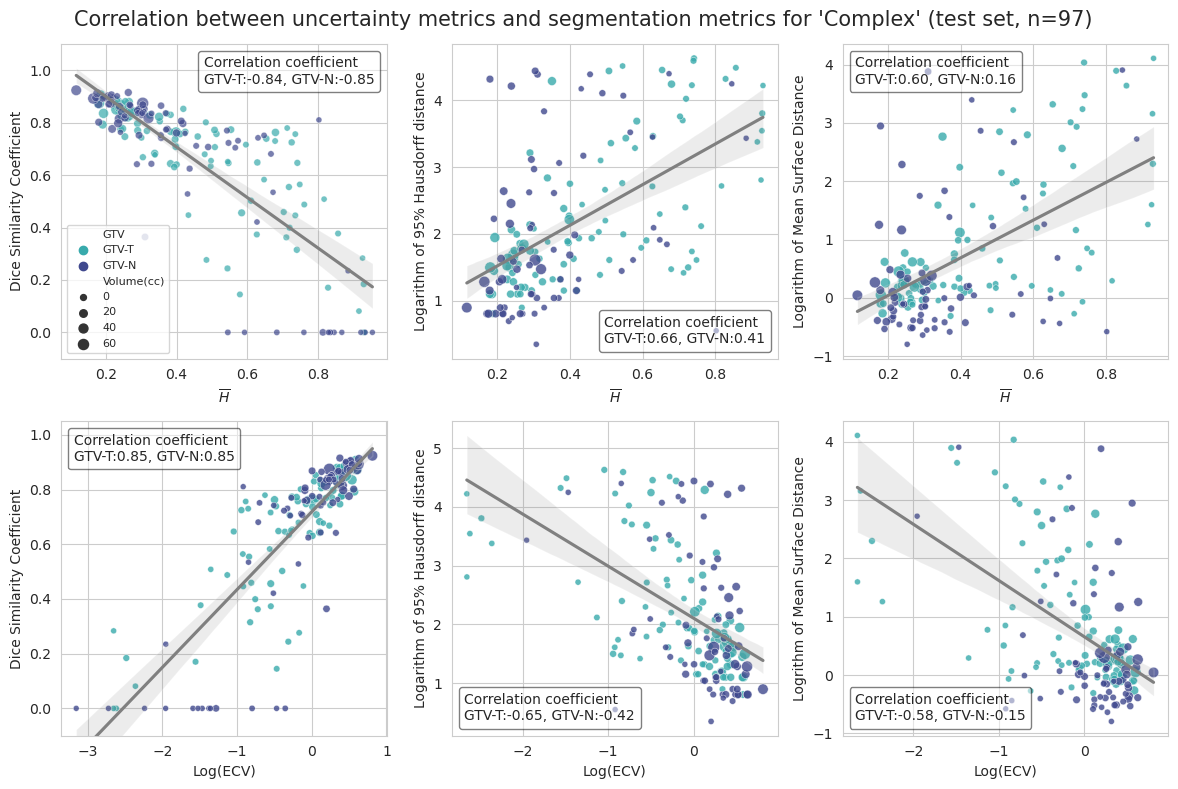

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=False)
sns.set_style("whitegrid")

fig.suptitle(f'Correlation between uncertainty metrics and segmentation metrics for \'{Task}\' (test set, n=97)' , size=15)
#fig.text(0.05, 0.95, 'B', size=30)

fig.tight_layout()

########## exp col 0
single_plot_data = entropy_plot_data[['DSC', 'Mean Entropy']].dropna()
new_entropy_plot_data  = entropy_plot_data

new_entropy_plot_data.rename(columns = {'Pred Volume (cc)':'Volume(cc)'}, inplace = True)

#print(entropy_plot_data[(entropy_plot_data['PatientID']=='HNCDL_095')])
y_exp = single_plot_data['DSC']
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0][0], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = new_entropy_plot_data['Volume(cc)'], legend='auto', alpha=0.7).set( ylabel='Dice Similarity Coefficient',xlabel='$\overline{H}$)')
sns.regplot(ax = axes[0][0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Dice Similarity Coefficient',xlabel='$\overline{H}$')
at00 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r00,n_r00),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
at00.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][0].add_artist(at00)

single_plot_data = entropy_plot_data[['DSC', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = single_plot_data['DSC']
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][0], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = new_entropy_plot_data['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Dice Similarity Coefficient',xlabel='Log(ECV)')
sns.regplot(ax = axes[1][0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Dice Similarity Coefficient',xlabel='Log(ECV)')
at10 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r10,n_r10),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at10.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][0].add_artist(at10)

########## exp col 1
single_plot_data = entropy_plot_data[['HD95 (mm)', 'Mean Entropy']].dropna()
y_exp = np.log(single_plot_data['HD95 (mm)'])
x_exp = single_plot_data['Mean Entropy']
sns.scatterplot(ax = axes[0][1], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = new_entropy_plot_data['Volume(cc)'], legend=False, alpha=0.8).set( ylabel='Logarithm of 95% Hausdorff distance',xlabel='$\overline{H}$')
sns.regplot(ax = axes[0][1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of 95% Hausdorff distance',xlabel='$\overline{H}$')
at01 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r01,n_r01),
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
at01.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

axes[0][1].add_artist(at01)
single_plot_data = entropy_plot_data[['HD95 (mm)', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = np.log(single_plot_data['HD95 (mm)'])
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][1], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = new_entropy_plot_data['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Logarithm of 95% Hausdorff distance', xlabel='Log(ECV)')
sns.regplot(ax = axes[1][1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of 95% Hausdorff distance',xlabel='Log(ECV)')
at11 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r11,n_r11),
                  prop=dict(size=10), frameon=True,
                  loc='lower left',
                  )
at11.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][1].add_artist(at11)

########## exp col 2
single_plot_data = entropy_plot_data[['Mean Surface Distance (mm)', 'Mean Entropy']].dropna()
y_exp = np.log(single_plot_data['Mean Surface Distance (mm)'])
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0][2], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = new_entropy_plot_data['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Logarithm of Mean Surface Distance',xlabel='$\overline{H}$')
sns.regplot(ax = axes[0][2], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of Mean Surface Distance',xlabel='$\overline{H}$')
at02 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r02,n_r02),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at02.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][2].add_artist(at02)

single_plot_data = entropy_plot_data[['Mean Surface Distance (mm)', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = np.log(single_plot_data['Mean Surface Distance (mm)'])
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][2], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = new_entropy_plot_data['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Logrithm of Mean Surface Distance',xlabel='Log(ECV)')
sns.regplot(ax = axes[1][2], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logrithm of Mean Surface Distance',xlabel='Log(ECV)')
at12 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r12,n_r12),
                  prop=dict(size=10), frameon=True,
                  loc='lower left',
                  )
at12.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][2].add_artist(at12)


# ########## exp col 3
# single_plot_data = entropy_plot_data[['Surface Dice 2mm', 'Mean Entropy']].dropna()
# y_exp = single_plot_data['Surface Dice 2mm']
# x_exp = single_plot_data['Mean Entropy']

# sns.scatterplot(ax = axes[0][3], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
#                 palette="mako_r",  
#                 size = new_entropy_plot_data['Volume(cc)'], legend= False, alpha=0.8).set(xlabel='$\overline{H}$')
# sns.regplot(ax = axes[0][3], x = x_exp, y = y_exp , scatter =False, color = 'grey').set(xlabel='$\overline{H}$')
# at03 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r03,n_r03),
#                   prop=dict(size=10), frameon=True,
#                   loc='lower left',
#                   )
# at03.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# axes[0][3].add_artist(at03)


# single_plot_data = entropy_plot_data[['Surface Dice 2mm', 'Logarithm Entropy Coefficient of Variation']].dropna()
# y_exp = single_plot_data['Surface Dice 2mm']
# x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

# sns.scatterplot(ax = axes[1][3], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
#                 palette="mako_r",  
#                 size = new_entropy_plot_data['Volume(cc)'], legend= False, alpha=0.8).set( xlabel='Log(ECV)')
# sns.regplot(ax = axes[1][3], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( xlabel='Log(ECV)')
# at13 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r13,n_r13),
#                   prop=dict(size=10), frameon=True,
#                   loc='upper left',
#                   )
# at13.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# axes[1][3].add_artist(at13)

# new_labels = ["GTVs regression","GTVs regression", "GTVs regression", "GTVs regression"]

ax00handles, ax00labels = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(labels=ax00labels, handles =ax00handles[:-1], loc='lower left', fontsize=8)
fig.tight_layout()
#plt.setp(axes[0][0].get_legend().get_texts(), fontsize='8')
axes[0][0].set_ylim(-0.1, 1.1)
axes[1][0].set_ylim(-0.1, 1.05)
#axes[1][0].set_xlim(-3, 1.08)

# axes[0][3].set_ylim(-0.1, 1.1)
# axes[1][3].set_ylim(-0.1, 1.1)

at00.patch.set_alpha(0.5)
at01.patch.set_alpha(0.5)
at02.patch.set_alpha(0.5)
# at03.patch.set_alpha(0.5)
at10.patch.set_alpha(0.5)
at11.patch.set_alpha(0.5)
at12.patch.set_alpha(0.5)
# at13.patch.set_alpha(0.5)


#fig.text(0.035, 0.95,'A', size=20, fontweight='semibold')
#fig.text(0.035, 0.45, 'B', size=20, fontweight='semibold')
#sns.move_legend(axes[0][3], "upper left", bbox_to_anchor=(0.7, 1),frameon=True,  borderaxespad=0)

plt.show()
fig.savefig("figures/fig_4_scatter.png", dpi=300) 
fig.savefig("figures/fig_4_scatter.svg") 


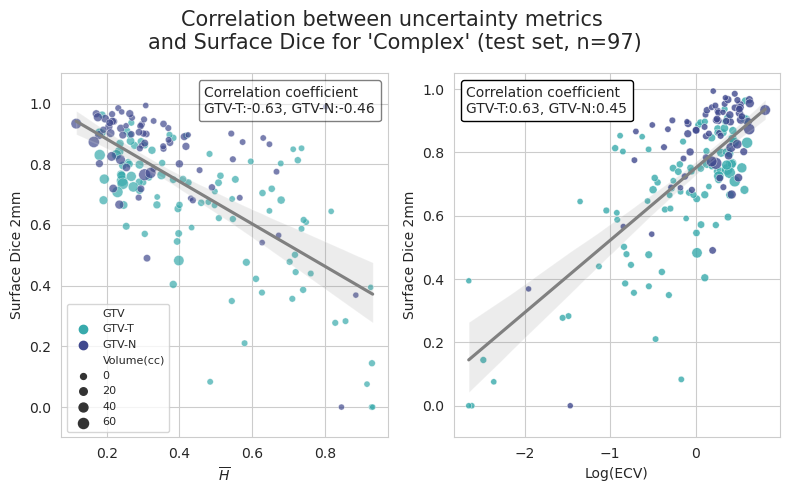

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=False)
sns.set_style("whitegrid")

fig.suptitle(f'Correlation between uncertainty metrics \nand Surface Dice for \'{Task}\' (test set, n=97)' , size=15)
#fig.text(0.05, 0.95, 'B', size=30)

fig.tight_layout()

########## exp col 0
single_plot_data = entropy_plot_data[['Surface Dice 2mm', 'Mean Entropy']].dropna()
new_entropy_plot_data  = entropy_plot_data

new_entropy_plot_data.rename(columns = {'Pred Volume (cc)':'Volume(cc)'}, inplace = True)

#print(entropy_plot_data[(entropy_plot_data['PatientID']=='HNCDL_095')])
y_exp = single_plot_data['Surface Dice 2mm']
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = new_entropy_plot_data['Volume(cc)'], legend='auto', alpha=0.7).set( ylabel='Surface Dice 2mm',xlabel='$\overline{H}$)')
sns.regplot(ax = axes[0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Surface Dice 2mm',xlabel='$\overline{H}$')
at00 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r03,n_r03),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
at00.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0].add_artist(at00)

single_plot_data = entropy_plot_data[['Surface Dice 2mm', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = single_plot_data['Surface Dice 2mm']
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1], x = x_exp, y = y_exp, hue = entropy_plot_data['GTV'],  
                palette="mako_r",  
                size = new_entropy_plot_data['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Surface Dice 2mm',xlabel='Log(ECV)')
sns.regplot(ax = axes[1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Surface Dice 2mm',xlabel='Log(ECV)')
at10 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r13,n_r13),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at10.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1].add_artist(at10)



ax00handles, ax00labels = axes[0].get_legend_handles_labels()
axes[0].legend(labels=ax00labels, handles =ax00handles[:-1], loc='lower left', fontsize=8)
fig.tight_layout()
#plt.setp(axes[0].get_legend().get_texts(), fontsize='8')
axes[0].set_ylim(-0.1, 1.1)
axes[1].set_ylim(-0.1, 1.05)
#axes[1].set_xlim(-3, 1.08)

# axes[0][3].set_ylim(-0.1, 1.1)
# axes[1][3].set_ylim(-0.1, 1.1)

at00.patch.set_alpha(0.5)
at01.patch.set_alpha(0.5)

# at03.patch.set_alpha(0.5)

# at13.patch.set_alpha(0.5)


#fig.text(0.035, 0.95,'A', size=20, fontweight='semibold')
#fig.text(0.035, 0.45, 'B', size=20, fontweight='semibold')
#sns.move_legend(axes[0][3], "upper left", bbox_to_anchor=(0.7, 1),frameon=True,  borderaxespad=0)

plt.show()
fig.savefig("figures/figure.a2_scatter.png", dpi=300) 
fig.savefig("figures/figure.a2_scatter.svg") 


In [37]:
np.log(19.1)

2.9496883350525844

In [22]:
entropy_plot_data[(entropy_plot_data['Mean Surface Distance (mm)']>5)& (entropy_plot_data['DSC']<0.5) & (entropy_plot_data['Mean Entropy']>0.5)]
#HNCDL_095 GTV-T DSC:0,   HD95:34.67mm, MSD:23.52, FDR:0.85, FNR:0.25, Mean Entropy:0.92, log(ECV):-2.61 ## highly uncertainty on GTV-T 
#HNCDL_095 GTV-N DSC:0.86, HD95:2.23mm,MSD:0.68, FDR:0.02, FNR:0.22, Mean Entropy:0.27, log(ECV):0.33 ## low uncertainty on GTV-N
#HNCDL_154 GTV-T DSC:0.84, HD95:5.7mm, MSD:1.85, FDR:0.25, FNR:0.04, Mean Entropy:0.29, log(ECV):0.29
#HNCDL_154 GTV-N DSC:0.23, HD95:31mm, MSD:15.25, FDR:0.64, FNR:0.82, Mean Entropy:0.89, log(ECV):-1.96 ## false postive GTV-N, 100/265
#HNCDL_368 GTV-T DSC:0.17, HD95:75.44, MSD:45, FDR:0.90,  FNR:0.54, Mean Entropy:0.83, log(ECV):-1.56
#HNCDL_301 outlier
#HNCDL_212 fit line of Dice
#HNCDL 628 bilatoral side of tonsil

,PatientID,Accuracy,Mean Surface Distance (mm),DSC,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,HD95 (mm),Jaccard,...,Ucertainty estimation methods,index,Total Entropy,Mean Entropy,Entropy STD,Entropy Volume,Entropy Coefficient of Variation,Logarithm Entropy Coefficient of Variation,AVD (cc),RAVD (cc)
15,HNCDL_095,0.999372,23.520050,0.000000,1.0,1.0,0.000436,0.000192,34.667708,0.0,...,Complex,15,15624.0,0.928711,0.067688,16827.0,0.072884,-2.618890,4.27,0.052941
30,HNCDL_181,0.999606,7.142331,0.243846,0.854224,0.254867,0.000022,0.000372,15.811388,0.138852,...,Complex,30,7380.0,0.543945,0.397217,13708.0,0.730250,-0.314368,6.96,0.052941
35,HNCDL_212,0.999405,18.827462,0.399181,0.574822,0.62382,0.000328,0.000267,55.959803,0.249361,...,Complex,35,12680.0,0.719727,0.337402,17626.0,0.468792,-0.757597,1.14,0.052941
37,HNCDL_233,0.999415,9.593902,0.362387,0.624077,0.650207,0.000309,0.000276,40.536403,0.22129,...,Complex,37,12560.0,0.710449,0.344727,17677.0,0.485223,-0.723147,0.58,0.052941
44,HNCDL_265,0.999586,5.994519,0.373353,0.692234,0.525535,0.000137,0.000277,15.066519,0.229523,...,Complex,44,8672.0,0.626953,0.362305,13828.0,0.577881,-0.548388,2.56,0.052941
49,HNCDL_282,0.999351,38.079135,0.377111,0.423211,0.719867,0.000505,0.000144,89.114533,0.23237,...,Complex,49,17136.0,0.856934,0.193481,20000.0,0.225783,-1.488180,6.66,0.052941
52,HNCDL_301,0.999693,60.861820,0.000000,1.0,1.0,0.000212,0.000096,68.278840,0.0,...,Complex,52,12960.0,0.931641,0.065491,13916.0,0.070296,-2.655040,2.05,0.052941
58,HNCDL_364,0.99564,9.975466,0.184115,0.088582,0.8976,0.004314,0.000048,45.001111,0.101391,...,Complex,58,56640.0,0.929688,0.077515,60914.0,0.083377,-2.484383,78.4,0.052941
59,HNCDL_368,0.999588,49.122456,0.170413,0.895566,0.537195,0.000049,0.000363,75.445674,0.093143,...,Complex,59,13200.0,0.828613,0.174683,15933.0,0.210813,-1.556784,6.04,0.052941
60,HNCDL_370,0.99946,56.576396,0.314841,0.770578,0.498405,0.000123,0.000417,99.020200,0.186831,...,Complex,60,18608.0,0.740234,0.324219,25123.0,0.437994,-0.825550,5.58,0.052941


In [23]:
entropy_plot_data[(entropy_plot_data['DSC']>0.8) & (entropy_plot_data['Mean Entropy']>0.7)]


,PatientID,Accuracy,Mean Surface Distance (mm),DSC,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,HD95 (mm),Jaccard,...,Ucertainty estimation methods,index,Total Entropy,Mean Entropy,Entropy STD,Entropy Volume,Entropy Coefficient of Variation,Logarithm Entropy Coefficient of Variation,AVD (cc),RAVD (cc)
149,HNCDL_301,0.999976,0.561568,0.810493,0.168059,0.209877,0.000013,0.00001,1.732051,0.681369,...,Complex,52,3334.0,0.802734,0.320312,4407.0,0.399026,-0.918728,0.05,0.052941


In [24]:
entropy_plot_data[(entropy_plot_data['PatientID']=='HNCDL_095')]

,PatientID,Accuracy,Mean Surface Distance (mm),DSC,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,HD95 (mm),Jaccard,...,Ucertainty estimation methods,index,Total Entropy,Mean Entropy,Entropy STD,Entropy Volume,Entropy Coefficient of Variation,Logarithm Entropy Coefficient of Variation,AVD (cc),RAVD (cc)
15,HNCDL_095,0.999372,23.520050,0.000000,1.0,1.0,0.000436,0.000192,34.667708,0.0,...,Complex,15,15624.0,0.928711,0.067688,16827.0,0.072884,-2.61889,4.27,0.052941
112,HNCDL_095,0.999878,0.682242,0.864012,0.020196,0.227304,0.000114,0.000008,2.236068,0.760582,...,Complex,15,1484.0,0.269287,0.377686,7894.0,1.402533,0.33828,1.86,0.052941


In [25]:
entropy_plot_data[(entropy_plot_data['PatientID']=='HNCDL_154')]

,PatientID,Accuracy,Mean Surface Distance (mm),DSC,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,HD95 (mm),Jaccard,...,Ucertainty estimation methods,index,Total Entropy,Mean Entropy,Entropy STD,Entropy Volume,Entropy Coefficient of Variation,Logarithm Entropy Coefficient of Variation,AVD (cc),RAVD (cc)
24,HNCDL_154,0.999438,1.851883,0.840338,0.250836,0.043222,0.000067,0.000496,5.744563,0.72464,...,Complex,24,11424.0,0.290039,0.390137,42868.0,1.345113,0.296478,7.72,0.052941
121,HNCDL_154,0.999866,15.253470,0.234736,0.648341,0.823837,0.000096,0.000038,31.000000,0.132975,...,Complex,24,2536.0,0.885254,0.125244,2865.0,0.141478,-1.955611,1.05,0.052941


In [26]:
entropy_plot_data[(entropy_plot_data['PatientID']=='HNCDL_368')]

,PatientID,Accuracy,Mean Surface Distance (mm),DSC,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,HD95 (mm),Jaccard,...,Ucertainty estimation methods,index,Total Entropy,Mean Entropy,Entropy STD,Entropy Volume,Entropy Coefficient of Variation,Logarithm Entropy Coefficient of Variation,AVD (cc),RAVD (cc)
59,HNCDL_368,0.999588,49.122456,0.170413,0.895566,0.537195,0.000049,0.000363,75.445674,0.093143,...,Complex,59,13200.0,0.828613,0.174683,15933.0,0.210813,-1.556784,6.04,0.052941
156,HNCDL_368,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Complex,59,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.052941


In [27]:
entropy_plot_data[(entropy_plot_data['PatientID']=='HNCDL_628')]['Surface Dice 2mm']

74     0.476895
171    0.802139
Name: Surface Dice 2mm, dtype: float64

# correlation between entorpy and segmentation metrics for external data


In [28]:
import SimpleITK as sitk
import numpy as np
from multiprocessing import Pool
from medpy.metric.binary import hd, asd
from scipy.ndimage import binary_erosion


DROP2_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
NNUNET_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_PMAPS="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"
PH_GAMM_PMAP="/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_PhiSeg_gamma__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct"


groups = {'No TTA': join(NNUNET_PMAPS,'f0')
          ,'Baseline': join(NNUNET_PMAPS,'f0_tta')
          ,'MC Dropout': join(DROP2_PMAPS,'f0_mc10_tta')
          ,'Ensemble': join(NNUNET_PMAPS,'f01234_tta')
          ,'Snapshots':join(DROP2_PMAPS,'f0_tta_snap')
          ,"Complex":join(DROP2_PMAPS,'f01234_mc10_tta_snap')
          ,'PhiSeg': join(PH_PMAPS,'f01234_tta')
          }

#Task = 'Snapshots' #'Snapshots' #Complex #PhiSeg #External #Baseline #"No TTA" #Ensemble #Snapshots
    ## complex
seg_folder = groups[Task]
umap_folder = seg_folder.replace("prob_maps","umaps")

## external
# seg_folder = '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/prob_maps/Task711_NKI_origin/imagesAll_ct_correct/f0_mc10_tta' #f01234_mc10_tta'
# umap_folder =  '/data/jintao/nnUNet/nnUNet_results/nnUNet/3d_fullres/Task901_AUH/nnUNetTrainerV2_dropout__nnUNetPlansv2.1/umaps/Task711_NKI_origin/imagesAll_ct_correct/f0_mc10_tta' #f01234_mc10_tta'

seg_files_in = subfiles(seg_folder, suffix=".nii.gz", join=False) 

umaps = [umap_folder] * len(seg_files_in)
segs = [seg_folder] * len(seg_files_in)

p = Pool(128)
entropy_results_external=  p.map(calcualte_target_entropy, zip(umaps, segs, seg_files_in))
p.close()
p.join()
#=========================================#
entropy_t = []
entropy_n = []
for result in entropy_results_external:
    entropy_t.append(result[0])
    entropy_n.append(result[1])
entropy_dft = pd.DataFrame(entropy_t)
entropy_dfn = pd.DataFrame(entropy_n)

entropy_df_all = pd.concat([entropy_dft, entropy_dfn], axis=0)
entropy_df_all = entropy_df_all.reset_index(drop=False)

complex_all_data = all_seg_carl_external[all_seg_carl_external["Uncertainty estimation methods"]==Task] # fetch data with the task name
complex_all_data_entropy_external = pd.merge(complex_all_data, entropy_df_all, how="inner", on=["PatientID", "GTV"]) # inner join between entropy and complex data


In [29]:
from matplotlib.offsetbox import AnchoredText
from medpy.metric.binary import ravd


complex_all_data_entropy_external['AVD (cc)'] = np.abs(complex_all_data_entropy_external['Pred Volume (cc)'] - complex_all_data_entropy_external['Volume (cc)'] )
complex_all_data_entropy_external['RAVD (cc)'] = ravd(complex_all_data_entropy_external['Pred Volume (cc)'] , complex_all_data_entropy_external['Volume (cc)'] )

complex_all_data_entropy_external.replace([np.inf, -np.inf], np.nan, inplace=True)

entropy_plot_data_external = complex_all_data_entropy_external.astype({"Entropy Coefficient of Variation": float, 
                                                    "DSC": float,
                                                    "Mean Surface Distance (mm)": float,
                                                    "HD95 (mm)": float,
                                                    "Mean Entropy": float,
                                                    "Entropy STD": float, 
                                                    "Entropy Volume" : float,
                                                    "Pred Volume (cc)" : float,
                                                    "Volume (cc)" : float,
                                                    "RAVD (cc)" : float,
                                                    "Surface Dice 2mm" : float
                                                    })



#entropy_plot_data_external = entropy_plot_data_external[entropy_plot_data_external['Pred Volume (cc)']>2] ## to test how much the no(small)-predicted case will impact the scores
 
r00,p00 = calcualte_corr(entropy_plot_data_external['Mean Entropy'], entropy_plot_data_external['DSC'], method = scipy.stats.spearmanr)
r01,p01 = calcualte_corr(entropy_plot_data_external['Mean Entropy'], np.log(entropy_plot_data_external['HD95 (mm)']), method = scipy.stats.spearmanr)
r02,p02 = calcualte_corr(entropy_plot_data_external['Mean Entropy'], np.log(entropy_plot_data_external['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
r03,p03 = calcualte_corr(entropy_plot_data_external['Mean Entropy'], entropy_plot_data_external['Surface Dice 2mm'], method = scipy.stats.spearmanr)

r10,p10 = calcualte_corr(entropy_plot_data_external['Logarithm Entropy Coefficient of Variation'], entropy_plot_data_external['DSC'], method = scipy.stats.spearmanr)
r11,p11 = calcualte_corr(entropy_plot_data_external['Logarithm Entropy Coefficient of Variation'], np.log(entropy_plot_data_external['HD95 (mm)']), method = scipy.stats.spearmanr)
r12,p12 = calcualte_corr(entropy_plot_data_external['Logarithm Entropy Coefficient of Variation'], np.log(entropy_plot_data_external['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
r13,p13 = calcualte_corr(entropy_plot_data_external['Logarithm Entropy Coefficient of Variation'], entropy_plot_data_external['Surface Dice 2mm'], method = scipy.stats.spearmanr)

entropy_stat_data = entropy_plot_data_external

t_r00,t_p00 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['DSC'], method = scipy.stats.spearmanr)
t_r01,t_p01 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['HD95 (mm)']), method = scipy.stats.spearmanr)
t_r02,t_p02 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
t_r03,t_p03 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Surface Dice 2mm'], method = scipy.stats.spearmanr)

t_r10,t_p10 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['DSC'], method = scipy.stats.spearmanr)
t_r11,t_p11 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['HD95 (mm)']), method = scipy.stats.spearmanr)
t_r12,t_p12 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
t_r13,t_p13 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Surface Dice 2mm'], method = scipy.stats.spearmanr)


n_r00,n_p00 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['DSC'], method = scipy.stats.spearmanr)
n_r01,n_p01 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['HD95 (mm)']), method = scipy.stats.spearmanr)
n_r02,n_p02 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
n_r03,n_p03 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Surface Dice 2mm'], method = scipy.stats.spearmanr)

n_r10,n_p10 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['DSC'], method = scipy.stats.spearmanr)
n_r11,n_p11 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['HD95 (mm)']), method = scipy.stats.spearmanr)
n_r12,n_p12 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
n_r13,n_p13 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Surface Dice 2mm'], method = scipy.stats.spearmanr)



-0.6911208584667591 1.8084219270980707e-63
0.4459194206603756 9.13228908198333e-22
0.35646866736331567 6.123347665561827e-14
-0.5283811121832142 2.318996674524826e-31
0.6922981935189249 9.138945715187295e-64
-0.4336890561919243 1.4941690674441058e-20
-0.35017115126448717 1.7893157350557188e-13
0.5379650156351852 1.1770716810147738e-32
-0.6881612838493321 1.3060032296859117e-33
0.5436477483381356 4.340162679126436e-19
0.43863439440883323 3.1129266885098626e-12
-0.5274761204263783 7.127197147386855e-18
0.6822897891131571 7.423892622845964e-33
-0.5444704822910895 3.748948078653815e-19
-0.4234141025103622 2.0218012288783937e-11
0.5279903934652928 6.535231556862759e-18
-0.6924065259267196 5.006173619380929e-31
0.4065136746149407 7.78868508228322e-09
0.24851984135304894 0.0006043891027989126
-0.4936107154106472 7.066849816148215e-13
0.6966096651686172 1.5574755222094377e-31
-0.3875928239307406 4.2420968094333976e-08
-0.24047287848813953 0.0009159376180798125
0.5035821903479056 2.038226492061

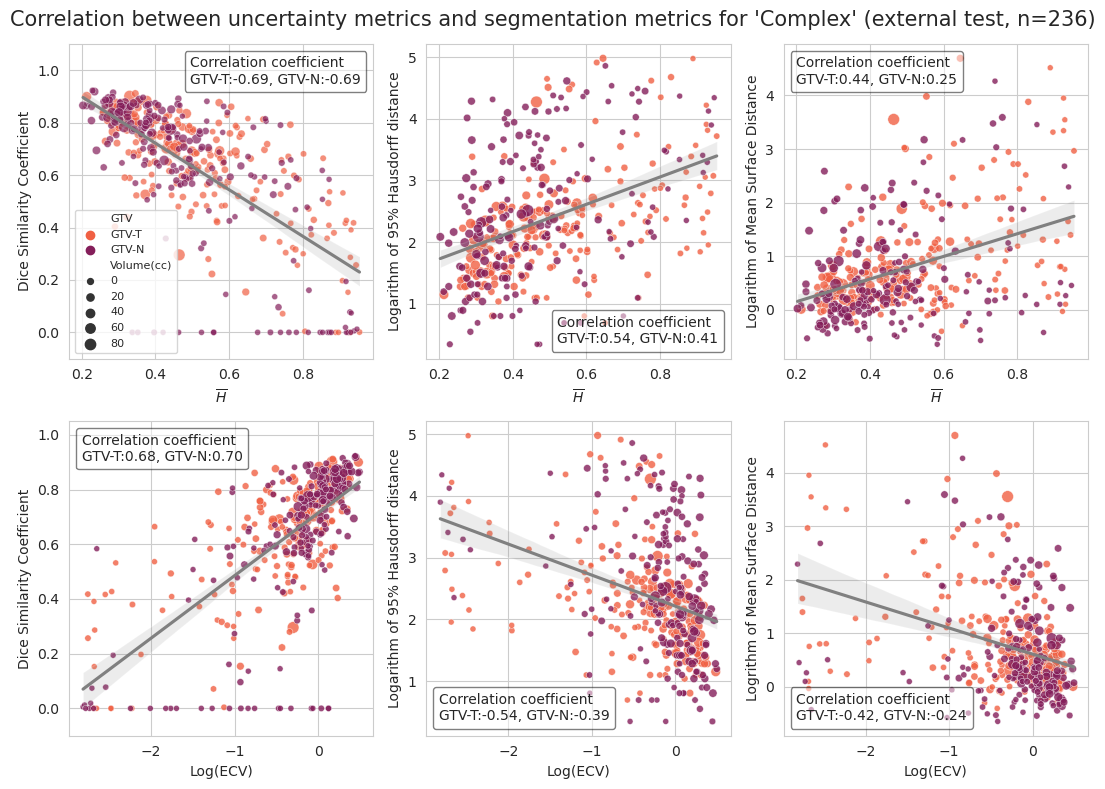

In [30]:

fig, axes = plt.subplots(2, 3, figsize=(11, 8), sharey=False)
sns.set_style("whitegrid")

fig.suptitle(f'Correlation between uncertainty metrics and segmentation metrics for \'{Task}\' (external test, n=236)' , size=15)
#fig.text(0.05, 0.95, 'B', size=30)

fig.tight_layout()
########## exp col 0
single_plot_data = entropy_plot_data_external[['DSC', 'Mean Entropy']].dropna()
new_entropy_plot_data_external  = entropy_plot_data_external

new_entropy_plot_data_external.rename(columns = {'Pred Volume (cc)':'Volume(cc)'}, inplace = True)

#print(entropy_plot_data_external[(entropy_plot_data_external['PatientID']=='HNCDL_095')])
y_exp = single_plot_data['DSC']
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0][0], x = x_exp, y = y_exp, hue = entropy_plot_data_external['GTV'],  
                palette="rocket_r",  
                size = new_entropy_plot_data_external['Volume(cc)'], legend='auto', alpha=0.7).set( ylabel='Dice Similarity Coefficient',xlabel='$\overline{H}$)')
sns.regplot(ax = axes[0][0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Dice Similarity Coefficient',xlabel='$\overline{H}$')
at00 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r00,n_r00),
                  prop=dict(size=10), frameon=True,
                  loc='upper right',
                  )
at00.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][0].add_artist(at00)

single_plot_data = entropy_plot_data_external[['DSC', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = single_plot_data['DSC']
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][0], x = x_exp, y = y_exp, hue = entropy_plot_data_external['GTV'],  
                palette="rocket_r",  
                size = new_entropy_plot_data_external['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Dice Similarity Coefficient',xlabel='Log(ECV)')
sns.regplot(ax = axes[1][0], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Dice Similarity Coefficient',xlabel='Log(ECV)')
at10 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r10,n_r10),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at10.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][0].add_artist(at10)

########## exp col 1
single_plot_data = entropy_plot_data_external[['HD95 (mm)', 'Mean Entropy']].dropna()
y_exp = np.log(single_plot_data['HD95 (mm)'])
x_exp = single_plot_data['Mean Entropy']
sns.scatterplot(ax = axes[0][1], x = x_exp, y = y_exp, hue = entropy_plot_data_external['GTV'],  
                palette="rocket_r",  
                size = new_entropy_plot_data_external['Volume(cc)'], legend=False, alpha=0.8).set( ylabel='Logarithm of 95% Hausdorff distance',xlabel='$\overline{H}$')
sns.regplot(ax = axes[0][1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of 95% Hausdorff distance',xlabel='$\overline{H}$')
at01 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r01,n_r01),
                  prop=dict(size=10), frameon=True,
                  loc='lower right',
                  )
at01.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

axes[0][1].add_artist(at01)
single_plot_data = entropy_plot_data_external[['HD95 (mm)', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = np.log(single_plot_data['HD95 (mm)'])
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][1], x = x_exp, y = y_exp, hue = entropy_plot_data_external['GTV'],  
                palette="rocket_r",  
                size = new_entropy_plot_data_external['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Logarithm of 95% Hausdorff distance', xlabel='Log(ECV)')
sns.regplot(ax = axes[1][1], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of 95% Hausdorff distance',xlabel='Log(ECV)')
at11 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r11,n_r11),
                  prop=dict(size=10), frameon=True,
                  loc='lower left',
                  )
at11.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][1].add_artist(at11)

########## exp col 2
single_plot_data = entropy_plot_data_external[['Mean Surface Distance (mm)', 'Mean Entropy']].dropna()
y_exp = np.log(single_plot_data['Mean Surface Distance (mm)'])
x_exp = single_plot_data['Mean Entropy']

sns.scatterplot(ax = axes[0][2], x = x_exp, y = y_exp, hue = entropy_plot_data_external['GTV'],  
                palette="rocket_r",  
                size = new_entropy_plot_data_external['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Logarithm of Mean Surface Distance',xlabel='$\overline{H}$')
sns.regplot(ax = axes[0][2], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logarithm of Mean Surface Distance',xlabel='$\overline{H}$')
at02 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r02,n_r02),
                  prop=dict(size=10), frameon=True,
                  loc='upper left',
                  )
at02.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[0][2].add_artist(at02)

single_plot_data = entropy_plot_data_external[['Mean Surface Distance (mm)', 'Logarithm Entropy Coefficient of Variation']].dropna()
y_exp = np.log(single_plot_data['Mean Surface Distance (mm)'])
x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

sns.scatterplot(ax = axes[1][2], x = x_exp, y = y_exp, hue = entropy_plot_data_external['GTV'],  
                palette="rocket_r",  
                size = new_entropy_plot_data_external['Volume(cc)'], legend= False, alpha=0.8).set( ylabel='Logrithm of Mean Surface Distance',xlabel='Log(ECV)')
sns.regplot(ax = axes[1][2], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( ylabel='Logrithm of Mean Surface Distance',xlabel='Log(ECV)')
at12 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r12,n_r12),
                  prop=dict(size=10), frameon=True,
                  loc='lower left',
                  )
at12.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axes[1][2].add_artist(at12)


# ########## exp col 3
# single_plot_data = entropy_plot_data_external[['Surface Dice 2mm', 'Mean Entropy']].dropna()
# y_exp = single_plot_data['Surface Dice 2mm']
# x_exp = single_plot_data['Mean Entropy']

# sns.scatterplot(ax = axes[0][3], x = x_exp, y = y_exp, hue = entropy_plot_data_external['GTV'],  
#                 palette="rocket_r",  
#                 size = new_entropy_plot_data_external['Volume(cc)'], legend= False, alpha=0.8).set(xlabel='$\overline{H}$')
# sns.regplot(ax = axes[0][3], x = x_exp, y = y_exp , scatter =False, color = 'grey').set(xlabel='$\overline{H}$')
# at03 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r03,n_r03),
#                   prop=dict(size=10), frameon=True,
#                   loc='lower left',
#                   )
# at03.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# axes[0][3].add_artist(at03)


# single_plot_data = entropy_plot_data_external[['Surface Dice 2mm', 'Logarithm Entropy Coefficient of Variation']].dropna()
# y_exp = single_plot_data['Surface Dice 2mm']
# x_exp = single_plot_data['Logarithm Entropy Coefficient of Variation']

# sns.scatterplot(ax = axes[1][3], x = x_exp, y = y_exp, hue = entropy_plot_data_external['GTV'],  
#                 palette="rocket_r",  
#                 size = new_entropy_plot_data_external['Volume(cc)'], legend= False, alpha=0.8).set( xlabel='Log(ECV)')
# sns.regplot(ax = axes[1][3], x = x_exp, y = y_exp , scatter =False, color = 'grey').set( xlabel='Log(ECV)')
# at13 = AnchoredText("Correlation coefficient\nGTV-T:%.2f, GTV-N:%.2f"%(t_r13,n_r13),
#                   prop=dict(size=10), frameon=True,
#                   loc='upper left',
#                   )
# at13.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# axes[1][3].add_artist(at13)

# new_labels = ["GTVs regression","GTVs regression", "GTVs regression", "GTVs regression"]

ax00handles, ax00labels = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(labels=ax00labels, handles =ax00handles[:-1], loc='lower left', fontsize=8)
fig.tight_layout()
#plt.setp(axes[0][0].get_legend().get_texts(), fontsize='8')
axes[0][0].set_ylim(-0.1, 1.1)
axes[1][0].set_ylim(-0.1, 1.05)
#axes[1][0].set_xlim(-3, 1.08)

# axes[0][3].set_ylim(-0.1, 1.1)
# axes[1][3].set_ylim(-0.1, 1.1)

at00.patch.set_alpha(0.5)
at01.patch.set_alpha(0.5)
at02.patch.set_alpha(0.5)
# at03.patch.set_alpha(0.5)
at10.patch.set_alpha(0.5)
at11.patch.set_alpha(0.5)
at12.patch.set_alpha(0.5)
# at13.patch.set_alpha(0.5)


#fig.text(0.035, 0.95,'A', size=20, fontweight='semibold')
#fig.text(0.035, 0.45, 'B', size=20, fontweight='semibold')
#sns.move_legend(axes[0][3], "upper left", bbox_to_anchor=(0.7, 1),frameon=True,  borderaxespad=0)


fig.savefig("figures/fig_5_scatter.png", dpi=300) 
fig.savefig("figures/fig_5_scatter.svg") 

## Statistics for correlation


external


In [31]:
from sklearn.metrics import *

def remove_nan(x, y):
    # method could also be pearsonr
    nas = np.logical_or(np.isnan(x), np.isnan(y)) # remove nan
    return x[~nas], y[~nas]  

## all GTV
entropy_stat_data = complex_all_data_entropy_external.astype({"Entropy Coefficient of Variation": float, 
                                                    "DSC": float,
                                                    "Mean Surface Distance (mm)": float,
                                                    "HD95 (mm)": float,
                                                    "Mean Entropy": float,
                                                    "Entropy STD": float, 
                                                    "Entropy Volume" : float,
                                                    "Pred Volume (cc)" : float,
                                                    "Volume (cc)" : float,
                                                    "RAVD (cc)" : float,
                                                    "Surface Dice 2mm" : float
                                                    })
                                                    
t_r00,t_p00 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['DSC'], method = scipy.stats.spearmanr)
t_r01,t_p01 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['HD95 (mm)']), method = scipy.stats.spearmanr)
t_r02,t_p02 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
t_r03,t_p03 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Surface Dice 2mm'], method = scipy.stats.spearmanr)

t_r10,t_p10 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['DSC'], method = scipy.stats.spearmanr)
t_r11,t_p11 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['HD95 (mm)']), method = scipy.stats.spearmanr)
t_r12,t_p12 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
t_r13,t_p13 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-T']['Surface Dice 2mm'], method = scipy.stats.spearmanr)


n_r00,n_p00 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['DSC'], method = scipy.stats.spearmanr)
n_r01,n_p01 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['HD95 (mm)']), method = scipy.stats.spearmanr)
n_r02,n_p02 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
n_r03,n_p03 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Entropy'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Surface Dice 2mm'], method = scipy.stats.spearmanr)

n_r10,n_p10 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['DSC'], method = scipy.stats.spearmanr)
n_r11,n_p11 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['HD95 (mm)']), method = scipy.stats.spearmanr)
n_r12,n_p12 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], np.log(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Mean Surface Distance (mm)']), method = scipy.stats.spearmanr)
n_r13,n_p13 = calcualte_corr(entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Logarithm Entropy Coefficient of Variation'], entropy_stat_data[entropy_stat_data['GTV']=='GTV-N']['Surface Dice 2mm'], method = scipy.stats.spearmanr)




-0.6881612838493321 1.3060032296859117e-33
0.5436477483381356 4.340162679126436e-19
0.43863439440883323 3.1129266885098626e-12
-0.5274761204263783 7.127197147386855e-18
0.6822897891131571 7.423892622845964e-33
-0.5444704822910895 3.748948078653815e-19
-0.4234141025103622 2.0218012288783937e-11
0.5279903934652928 6.535231556862759e-18
-0.6924065259267196 5.006173619380929e-31
0.4065136746149407 7.78868508228322e-09
0.24851984135304894 0.0006043891027989126
-0.4936107154106472 7.066849816148215e-13
0.6966096651686172 1.5574755222094377e-31
-0.3875928239307406 4.2420968094333976e-08
-0.24047287848813953 0.0009159376180798125
0.5035821903479056 2.0382264920610455e-13
